In [26]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.metrics import mean_squared_error
import joblib
from sklearn.model_selection import GridSearchCV, train_test_split
import warnings

# Data behandling

In [27]:
data = pd.read_csv('case1Data.txt', sep=',', skipinitialspace=True)
data.head()

y       x_ 1       x_ 2      x_ 3      x_ 4       x_ 5      x_ 6  \
0  90.685036        NaN        NaN -3.978178 -1.504027 -14.986790  0.651581   
1  60.844445  26.204958  11.185962 -8.247602 -3.875866 -11.329702  2.637900   
2  18.062345  18.560873  11.355342 -9.370161 -3.745315 -16.292421 -1.831774   
3  -8.139839  31.896496  10.069040 -9.484426 -1.512786 -11.421909 -5.649180   
4  -4.994792  25.400286        NaN -3.600959 -2.615988 -15.455676 -4.950816   

        x_ 7       x_ 8      x_ 9  ...       x_91      x_92       x_93  \
0 -37.878245  16.213807 -3.965437  ...  -7.032047  6.319109        NaN   
1 -39.617497        NaN -2.442164  ... -13.437474       NaN -12.880342   
2 -37.584605  14.411348 -2.376175  ... -12.291624  2.664209 -15.803518   
3 -42.830037  18.403197 -7.791762  ... -13.253436  5.004891 -13.879328   
4 -39.932456        NaN -7.341165  ...        NaN  5.101262 -16.938532   

        x_94       x_95  C_ 1  C_ 2  C_ 3  C_ 4  C_ 5  
0  26.197445  -9.913837     H     H     I     K     J  
1  25.924603  -7.015803     K     H     J     G     G  
2  24.293073 -14.795709     I     H     G     H     G  
3  25.954304  -9.365574   NaN     H     K     K     G  
4  22.611184 -17.240003     G     H     H     K     H  

[5 rows x 101 columns]

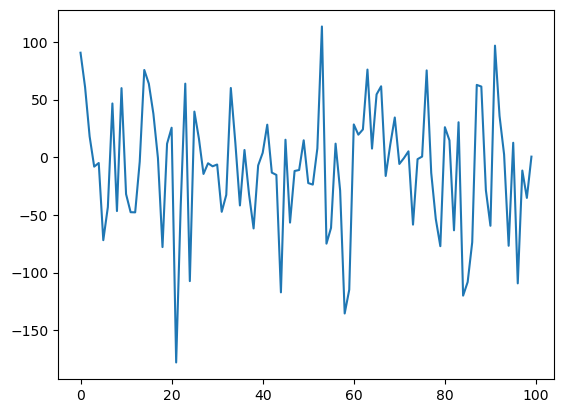

In [28]:
plt.plot(data['y'])

In [29]:
y_mean = data['y'].mean()
y_std = data['y'].std()
print(f'y mean {y_mean}')
print(f'ystd {y_std}')

y mean -9.44922526
ystd 54.637474607050535


Tjekker for NaN værdier i $C_1, C_2, C_3, C_4$ og  $C_5$

In [30]:
data_cat = data[['C_ 1', 'C_ 2', 'C_ 3', 'C_ 4', 'C_ 5']]
print(f'Antallet af NaN værdier for de forskellige kategorier er givet ved: \n{data_cat.isnull().sum()}')

Antallet af NaN værdier for de forskellige kategorier er givet ved: 
C_ 1    28
C_ 2     0
C_ 3     0
C_ 4     0
C_ 5     0
dtype: int64


Tjekker for correlation imellem de 5 vektorer som er kategorier, for at se, om vi kan droppe $C_1$. Til dette laver jeg one hot encoding
- Der er ikke nogle korrelation. Grunden til at 'C_ 2_H' ikke er blevet plottet er fordi der ikke er noget varians i denne


<Axes: >

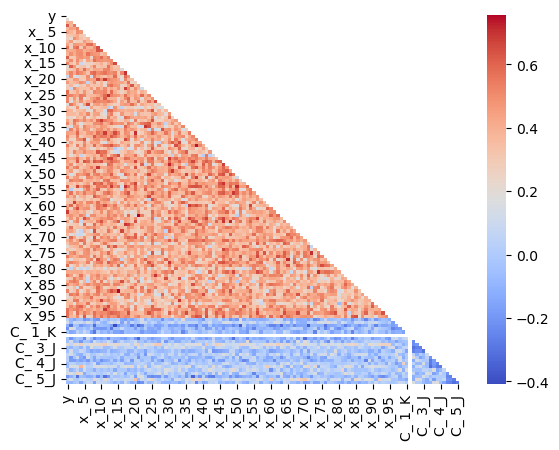

In [31]:
data_encoded_tot = pd.get_dummies(data)
correlation_matrix = data_encoded_tot.corr()
mask = np.triu(np.ones_like(correlation_matrix)) 
sns.heatmap(correlation_matrix, cmap='coolwarm', mask = mask)

<Axes: >

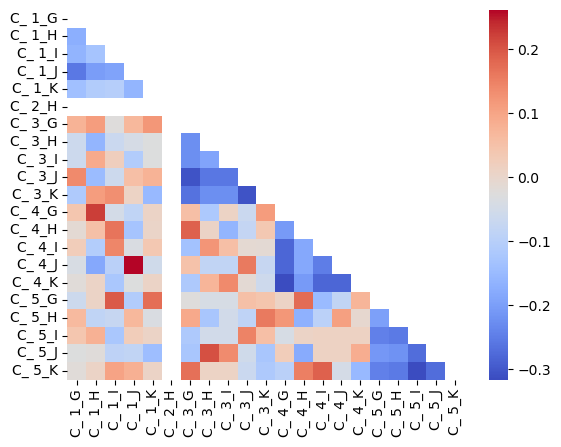

In [32]:
data_encoded_cat = pd.get_dummies(data_cat)
correlation_matrix = data_encoded_cat.corr()
mask = np.triu(np.ones_like(correlation_matrix)) 
sns.heatmap(correlation_matrix, cmap='coolwarm', mask = mask)

Ser hvordan fordelingen af kategorierne i $C_1$ er, for at undersøge, om vi kan erstatte alle NaN med et specifikt svar
- Det er ikke tilfældet

<Axes: xlabel='C_ 1'>

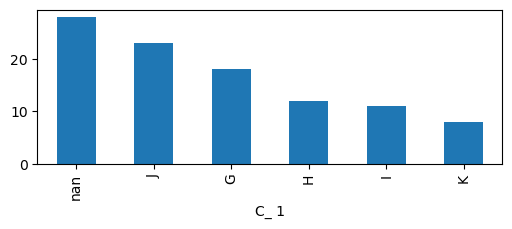

In [33]:
count_C1 = data_cat['C_ 1'].value_counts(dropna=False)
plt.figure(figsize=(6,2))
count_C1.plot(kind='bar')

Erstatter værdierne i one hot encoding for 'C_ 1' med NaN de steder, hvor de var i den orginale vektor. Håbet er at bruge KNN på alle one hot encoding til at finde en værdi for kategorien, de steder, hvor der var NaN. Problemet med dette er, at der kan forekomme scenarie med 2 svar på samme række for one hot encoding, hvilket der skal tjekkes for

In [34]:
data_encoded = pd.get_dummies(data_cat).astype(int)
C1_dummy = pd.get_dummies(data['C_ 1'], dummy_na=True).astype(int)
NaN_col = C1_dummy.iloc[:, -1]
data_encoded.loc[NaN_col == 1, data_encoded.columns[:5]] = np.nan
data_encoded.head()

C_ 1_G  C_ 1_H  C_ 1_I  C_ 1_J  C_ 1_K  C_ 2_H  C_ 3_G  C_ 3_H  C_ 3_I  \
0     0.0     1.0     0.0     0.0     0.0       1       0       0       1   
1     0.0     0.0     0.0     0.0     1.0       1       0       0       0   
2     0.0     0.0     1.0     0.0     0.0       1       1       0       0   
3     NaN     NaN     NaN     NaN     NaN       1       0       0       0   
4     1.0     0.0     0.0     0.0     0.0       1       0       1       0   

   C_ 3_J  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  C_ 4_K  C_ 5_G  C_ 5_H  \
0       0  ...       0       0       0       0       1       0       0   
1       1  ...       1       0       0       0       0       1       0   
2       0  ...       0       1       0       0       0       1       0   
3       0  ...       0       0       0       0       1       1       0   
4       0  ...       0       0       0       0       1       0       1   

   C_ 5_I  C_ 5_J  C_ 5_K  
0       0       1       0  
1       0       0       0  
2       0       0       0  
3       0       0       0  
4       0       0       0  

[5 rows x 21 columns]

Sammensætter kategori med kontinuerlig data, hvor mit kontinuerlig data er blevet normaliseret ved brug af z-transform

In [35]:
data_norm = data.copy()
scaler = StandardScaler()
data_norm.iloc[:, :96] = scaler.fit_transform(data_norm.iloc[:, :96])
scaler_filename = 'scaler.pkl'
joblib.dump(scaler, scaler_filename)

data_tot = pd.concat([data_norm.iloc[:,:96],data_encoded], axis=1)
data_tot.iloc[:,90:].head()

x_90      x_91      x_92      x_93      x_94      x_95  C_ 1_G  C_ 1_H  \
0  2.284429  2.427215  0.665343       NaN  1.021911  1.103443     0.0     1.0   
1 -0.784123  0.339025       NaN  1.142396  0.923233  2.035764     0.0     0.0   
2 -0.153389  0.712576 -0.711439  0.077127  0.333162 -0.467096     0.0     0.0   
3  0.499961  0.399022  0.170284  0.778344  0.933975  1.279824     NaN     NaN   
4  0.837954       NaN  0.206586 -0.336497 -0.275123 -1.253445     1.0     0.0   

   C_ 1_I  C_ 1_J  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  C_ 4_K  C_ 5_G  \
0     0.0     0.0  ...       0       0       0       0       1       0   
1     0.0     0.0  ...       1       0       0       0       0       1   
2     1.0     0.0  ...       0       1       0       0       0       1   
3     NaN     NaN  ...       0       0       0       0       1       1   
4     0.0     0.0  ...       0       0       0       0       1       0   

   C_ 5_H  C_ 5_I  C_ 5_J  C_ 5_K  
0       0       0       1       0  
1       0       0       0       0  
2       0       0       0       0  
3       0       0       0       0  
4       1       0       0       0  

[5 rows x 27 columns]

Tjekker for pattern i mit data

<Axes: >

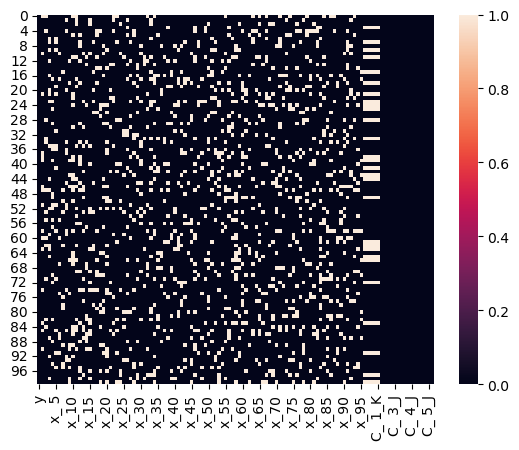

In [36]:
sns.heatmap(data_tot.isnull())

Laver KNN og tjekker om der stadig er nogle tomme rækker i 'C_ 1'

In [37]:
K = 6
knn_imputer = KNNImputer(n_neighbors=K, weights='distance') 
data_imputed = pd.DataFrame(knn_imputer.fit_transform(data_tot), columns=data_tot.columns)
data_imputed.head()

y      x_ 1      x_ 2      x_ 3      x_ 4      x_ 5      x_ 6  \
0  1.841936 -0.052675  0.289440  1.812241  0.987260  0.501513  1.181534   
1  1.293028  0.640019 -0.134319  0.470501  0.071322  1.805918  1.859452   
2  0.506066 -1.743380 -0.069207  0.117717  0.121737  0.035823  0.333980   
3  0.024086  2.414620 -0.563680  0.081807  0.983877  1.773029 -0.968877   
4  0.081938  0.389125  0.248743  1.930789  0.557851  0.334272 -0.730530   

       x_ 7      x_ 8      x_ 9  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  C_ 4_K  \
0  0.362511  0.294815  0.309919  ...     0.0     0.0     0.0     0.0     1.0   
1 -0.419828  0.726471  0.852108  ...     1.0     0.0     0.0     0.0     0.0   
2  0.494595 -0.302296  0.875596  ...     0.0     1.0     0.0     0.0     0.0   
3 -1.864873  1.020107 -1.052012  ...     0.0     0.0     0.0     0.0     1.0   
4 -0.561501 -0.142450 -0.891628  ...     0.0     0.0     0.0     0.0     1.0   

   C_ 5_G  C_ 5_H  C_ 5_I  C_ 5_J  C_ 5_K  
0     0.0     0.0     0.0     1.0     0.0  
1     1.0     0.0     0.0     0.0     0.0  
2     1.0     0.0     0.0     0.0     0.0  
3     1.0     0.0     0.0     0.0     0.0  
4     0.0     1.0     0.0     0.0     0.0  

[5 rows x 117 columns]

In [38]:
data_imputed.iloc[:,96:101].head(10)

C_ 1_G    C_ 1_H    C_ 1_I    C_ 1_J    C_ 1_K
0  0.000000  1.000000  0.000000  0.000000  0.000000
1  0.000000  0.000000  0.000000  0.000000  1.000000
2  0.000000  0.000000  1.000000  0.000000  0.000000
3  0.172212  0.171708  0.326799  0.167075  0.162206
4  1.000000  0.000000  0.000000  0.000000  0.000000
5  0.000000  0.000000  1.000000  0.000000  0.000000
6  0.000000  0.000000  0.000000  1.000000  0.000000
7  0.677406  0.000000  0.000000  0.322594  0.000000
8  0.000000  0.000000  0.000000  1.000000  0.000000
9  0.169477  0.159031  0.000000  0.507316  0.164176

In [39]:
def replace_max_value(row):
    maks_værdi = row.max()
    return row.apply(lambda x: 1 if x == maks_værdi else 0)

data_imputed.iloc[:,96:101] = data_imputed.iloc[:,96:101].apply(replace_max_value, axis=1)
data_imputed.iloc[:,94:].head(10)


x_94      x_95  C_ 1_G  C_ 1_H  C_ 1_I  C_ 1_J  C_ 1_K  C_ 2_H  C_ 3_G  \
0  1.021911  1.103443     0.0     1.0     0.0     0.0     0.0     1.0     0.0   
1  0.923233  2.035764     0.0     0.0     0.0     0.0     1.0     1.0     0.0   
2  0.333162 -0.467096     0.0     0.0     1.0     0.0     0.0     1.0     1.0   
3  0.933975  1.279824     0.0     0.0     1.0     0.0     0.0     1.0     0.0   
4 -0.275123 -1.253445     1.0     0.0     0.0     0.0     0.0     1.0     0.0   
5 -1.664137 -1.462863     0.0     0.0     1.0     0.0     0.0     1.0     0.0   
6 -0.514772 -1.378834     0.0     0.0     0.0     1.0     0.0     1.0     1.0   
7  0.621830  1.354484     1.0     0.0     0.0     0.0     0.0     1.0     0.0   
8  0.618650 -0.701191     0.0     0.0     0.0     1.0     0.0     1.0     0.0   
9  0.536660  0.194625     0.0     0.0     0.0     1.0     0.0     1.0     0.0   

   C_ 3_H  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  C_ 4_K  C_ 5_G  C_ 5_H  \
0     0.0  ...     0.0     0.0     0.0     0.0     1.0     0.0     0.0   
1     0.0  ...     1.0     0.0     0.0     0.0     0.0     1.0     0.0   
2     0.0  ...     0.0     1.0     0.0     0.0     0.0     1.0     0.0   
3     0.0  ...     0.0     0.0     0.0     0.0     1.0     1.0     0.0   
4     1.0  ...     0.0     0.0     0.0     0.0     1.0     0.0     1.0   
5     0.0  ...     0.0     0.0     0.0     1.0     0.0     0.0     0.0   
6     0.0  ...     0.0     0.0     0.0     0.0     1.0     0.0     1.0   
7     1.0  ...     0.0     0.0     0.0     1.0     0.0     0.0     0.0   
8     1.0  ...     0.0     0.0     1.0     0.0     0.0     0.0     0.0   
9     0.0  ...     0.0     1.0     0.0     0.0     0.0     0.0     0.0   

   C_ 5_I  C_ 5_J  C_ 5_K  
0     0.0     1.0     0.0  
1     0.0     0.0     0.0  
2     0.0     0.0     0.0  
3     0.0     0.0     0.0  
4     0.0     0.0     0.0  
5     0.0     0.0     1.0  
6     0.0     0.0     0.0  
7     0.0     1.0     0.0  
8     0.0     0.0     1.0  
9     1.0     0.0     0.0  

[10 rows x 23 columns]

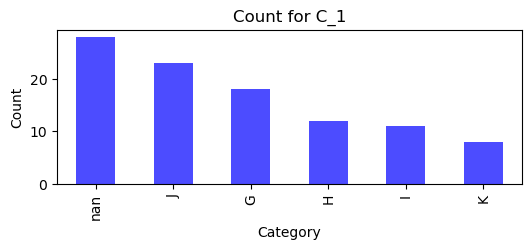

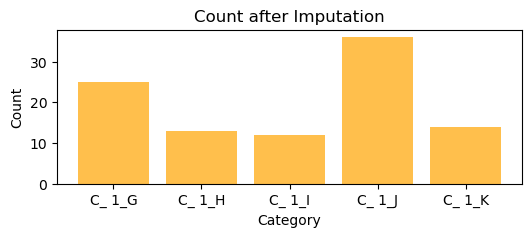

In [40]:
count_C1 = data_cat['C_ 1'].value_counts(dropna=False)
count_after = data_imputed.iloc[:, 96:101].sum()

# Plot count_C1
plt.figure(figsize=(6, 2))
count_C1.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Count for C_1')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

# Plot count_after
plt.figure(figsize=(6, 2))
plt.bar(count_after.index, count_after, color='orange', alpha=0.7)
plt.title('Count after Imputation')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [41]:
scaler = joblib.load(scaler_filename)
data_done = data_tot.copy()
data_done.iloc[:, :96] = scaler.inverse_transform(data_imputed.iloc[:, :96].values)
data_done.iloc[:, 96:] = data_imputed.iloc[:, 96:]
data_done.head()


y       x_ 1       x_ 2      x_ 3      x_ 4       x_ 5      x_ 6  \
0  90.685036  23.983338  12.288310 -3.978178 -1.504027 -14.986790  0.651581   
1  60.844445  26.204958  11.185962 -8.247602 -3.875866 -11.329702  2.637900   
2  18.062345  18.560873  11.355342 -9.370161 -3.745315 -16.292421 -1.831774   
3  -8.139839  31.896496  10.069040 -9.484426 -1.512786 -11.421909 -5.649180   
4  -4.994792  25.400286  12.182442 -3.600959 -2.615988 -15.455676 -4.950816   

        x_ 7       x_ 8      x_ 9  ...  C_ 4_G  C_ 4_H  C_ 4_I  C_ 4_J  \
0 -37.878245  16.213807 -3.965437  ...     0.0     0.0     0.0     0.0   
1 -39.617497  17.516819 -2.442164  ...     1.0     0.0     0.0     0.0   
2 -37.584605  14.411348 -2.376175  ...     0.0     1.0     0.0     0.0   
3 -42.830037  18.403197 -7.791762  ...     0.0     0.0     0.0     0.0   
4 -39.932456  14.893863 -7.341165  ...     0.0     0.0     0.0     0.0   

   C_ 4_K  C_ 5_G  C_ 5_H  C_ 5_I  C_ 5_J  C_ 5_K  
0     1.0     0.0     0.0     0.0     1.0     0.0  
1     0.0     1.0     0.0     0.0     0.0     0.0  
2     0.0     1.0     0.0     0.0     0.0     0.0  
3     1.0     1.0     0.0     0.0     0.0     0.0  
4     1.0     0.0     1.0     0.0     0.0     0.0  

[5 rows x 117 columns]

In [42]:
data.head()

y       x_ 1       x_ 2      x_ 3      x_ 4       x_ 5      x_ 6  \
0  90.685036        NaN        NaN -3.978178 -1.504027 -14.986790  0.651581   
1  60.844445  26.204958  11.185962 -8.247602 -3.875866 -11.329702  2.637900   
2  18.062345  18.560873  11.355342 -9.370161 -3.745315 -16.292421 -1.831774   
3  -8.139839  31.896496  10.069040 -9.484426 -1.512786 -11.421909 -5.649180   
4  -4.994792  25.400286        NaN -3.600959 -2.615988 -15.455676 -4.950816   

        x_ 7       x_ 8      x_ 9  ...       x_91      x_92       x_93  \
0 -37.878245  16.213807 -3.965437  ...  -7.032047  6.319109        NaN   
1 -39.617497        NaN -2.442164  ... -13.437474       NaN -12.880342   
2 -37.584605  14.411348 -2.376175  ... -12.291624  2.664209 -15.803518   
3 -42.830037  18.403197 -7.791762  ... -13.253436  5.004891 -13.879328   
4 -39.932456        NaN -7.341165  ...        NaN  5.101262 -16.938532   

        x_94       x_95  C_ 1  C_ 2  C_ 3  C_ 4  C_ 5  
0  26.197445  -9.913837     H     H     I     K     J  
1  25.924603  -7.015803     K     H     J     G     G  
2  24.293073 -14.795709     I     H     G     H     G  
3  25.954304  -9.365574   NaN     H     K     K     G  
4  22.611184 -17.240003     G     H     H     K     H  

[5 rows x 101 columns]

# Tjekker om mine nye værdier ved brug af KNN giver mening

## Korrelation

Nedenfor tjekker jeg min korrelation mellem oprindelig data og behandlet data



<Axes: >

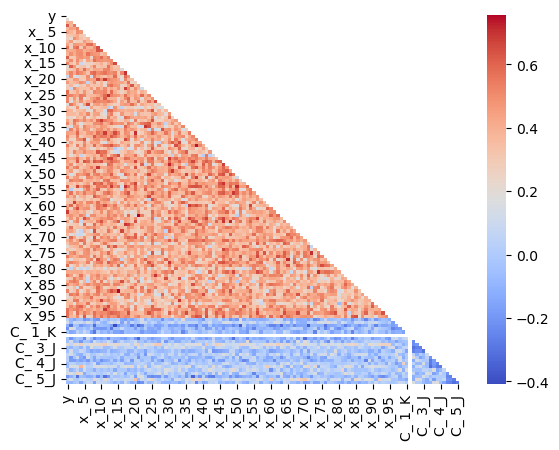

In [43]:
data_encoded_tot = pd.get_dummies(data)
correlation_matrix = data_encoded_tot.corr() 
mask = np.triu(np.ones_like(correlation_matrix)) 
sns.heatmap(correlation_matrix, cmap='coolwarm', mask = mask)

Korrelationsplot for nuværende data

<Axes: >

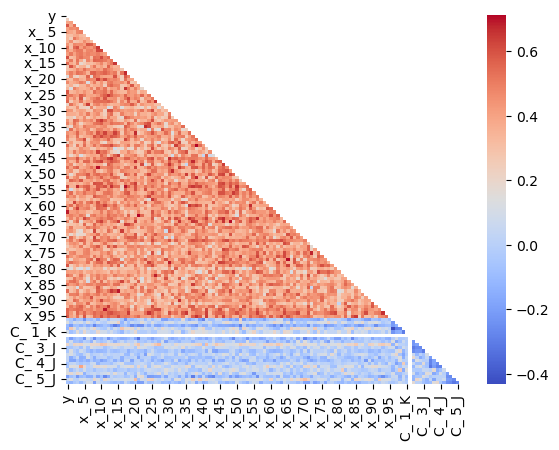

In [44]:
data_encoded_tot = pd.get_dummies(data)
correlation_matrix = data_done.corr()
mask = np.triu(np.ones_like(correlation_matrix)) 
sns.heatmap(correlation_matrix, cmap='coolwarm', mask = mask)

Korrelationsplot som viser forskellen mellem oprindelig og nuværende data
- vi har fået ændret korrelationen for C_1 en del 

<Axes: >

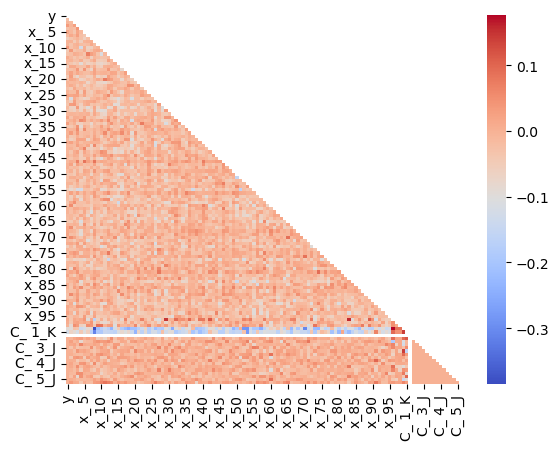

In [45]:
data_encoded_tot = pd.get_dummies(data)
correlation_matrix = data_encoded_tot.corr() - data_done.corr()
mask = np.triu(np.ones_like(correlation_matrix)) 
sns.heatmap(correlation_matrix, cmap='coolwarm', mask = mask)

Korrelation mellem de numeriske værdier

<Axes: >

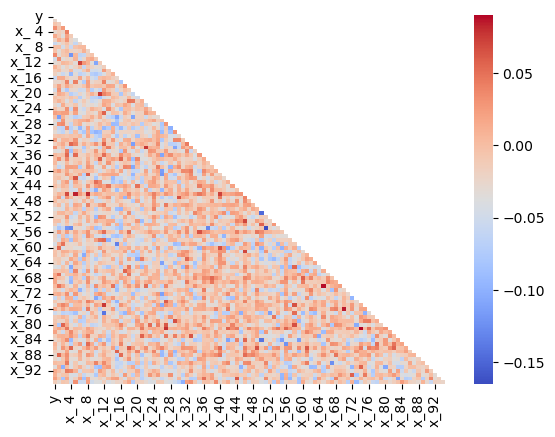

In [46]:
data_encoded_tot = pd.get_dummies(data)
correlation_matrix = data_encoded_tot.iloc[:, :96].corr() - data_done.iloc[:, :96].corr()
mask = np.triu(np.ones_like(correlation_matrix)) 
sns.heatmap(correlation_matrix, cmap='coolwarm', mask = mask)

Ud fra det ovenfor så ser det ud til at min kategoriske variable har ændre min korrelation lidt men det er stadig okay

## Kernal density plot
Nedenfor ses kernal dencity plot for mine variabler fra den oprindelig og behanldet data. Det er en tendens til, at mit data efter behandlingen er mere centeret omkring gennemsnitværdien

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


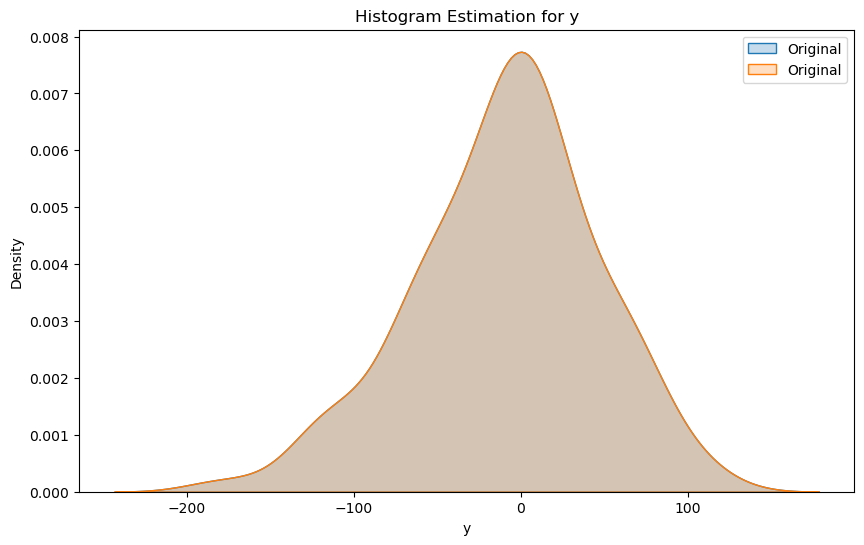

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


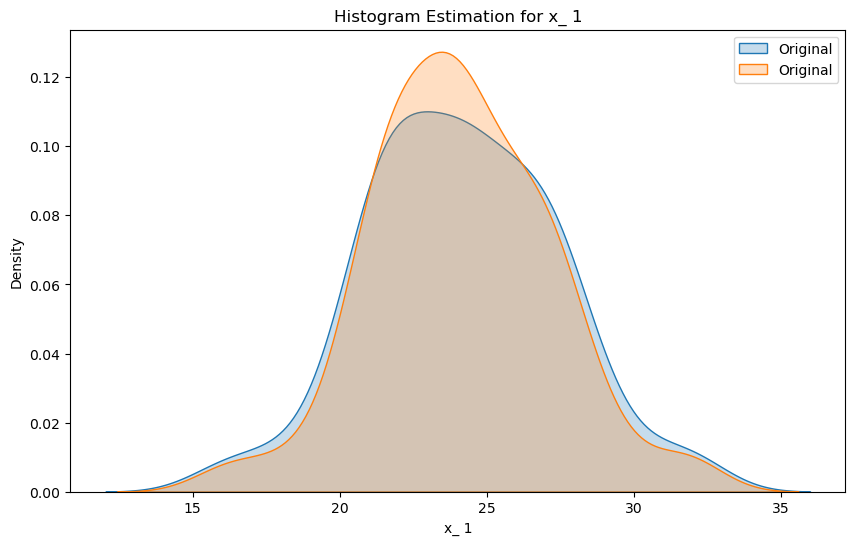

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


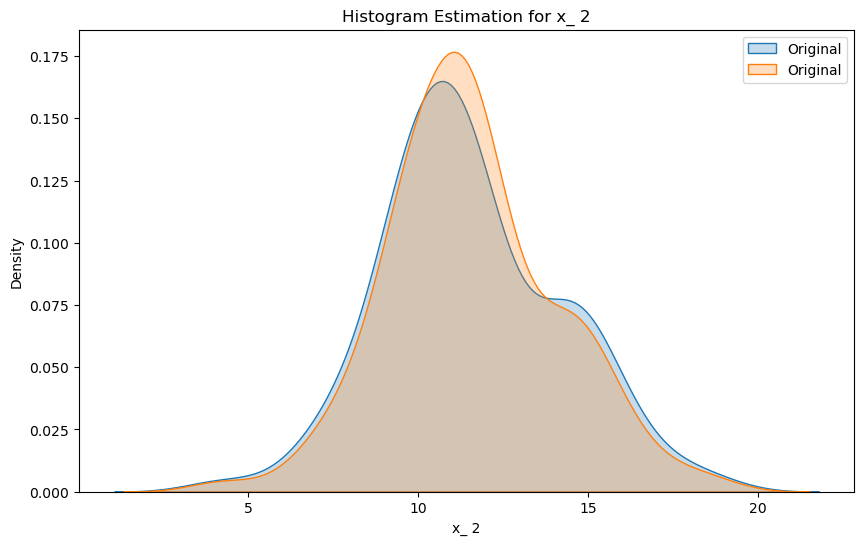

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


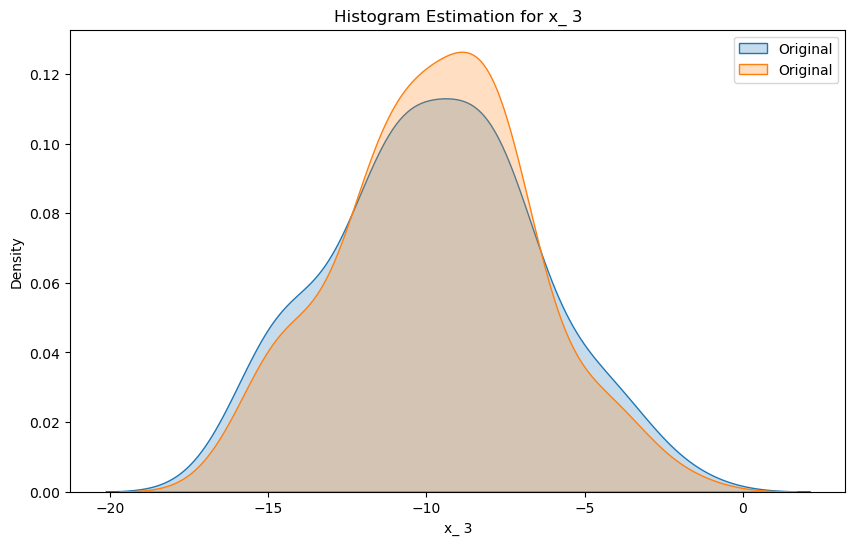

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


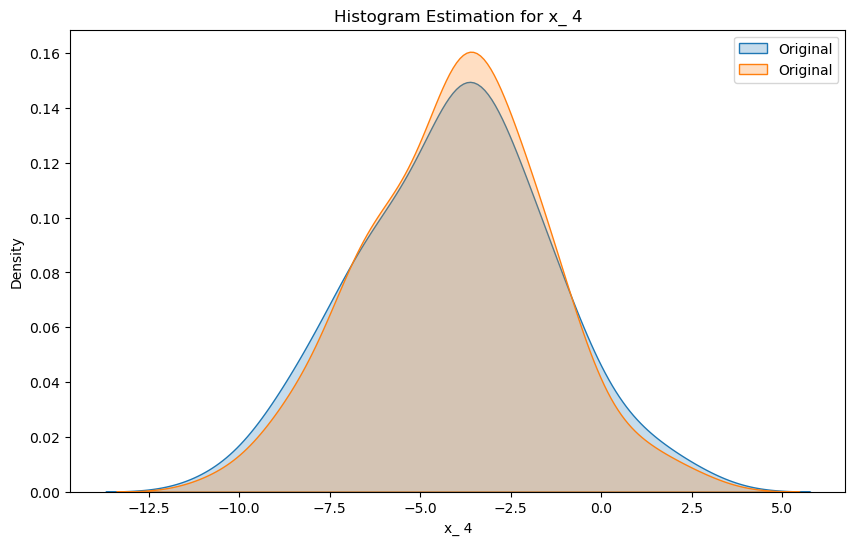

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


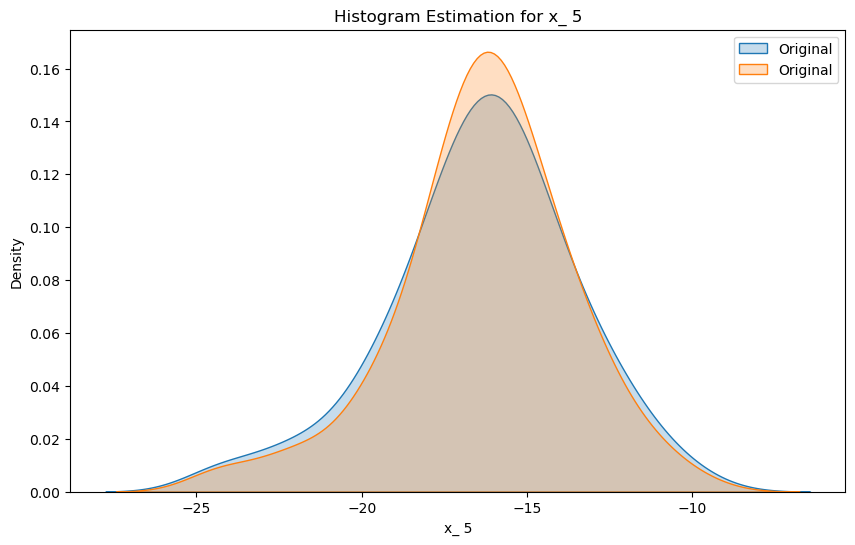

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


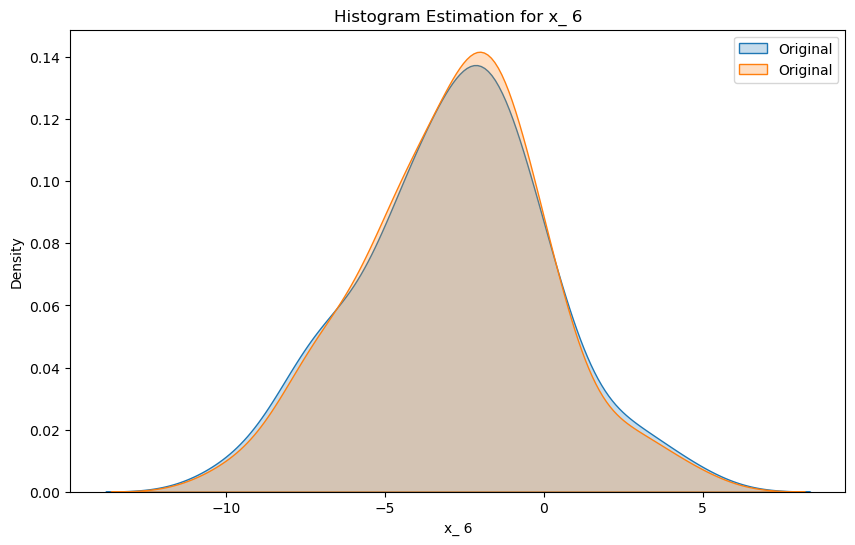

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


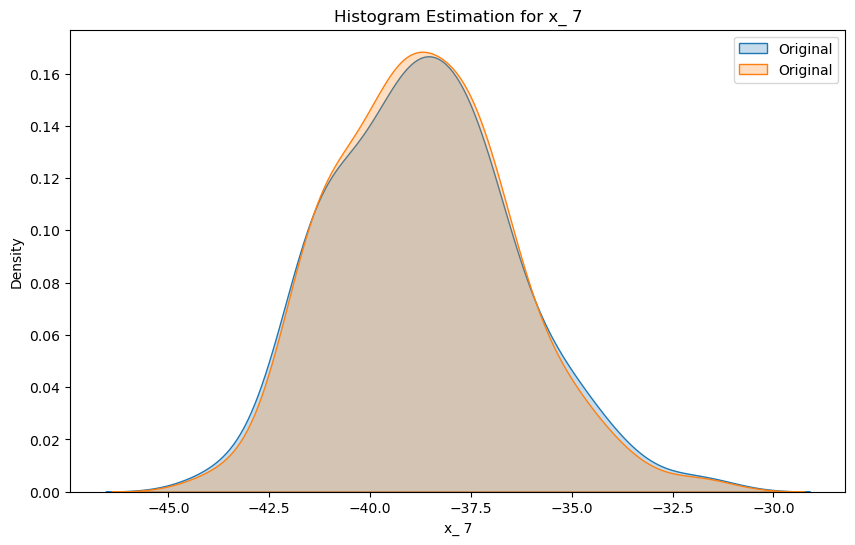

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


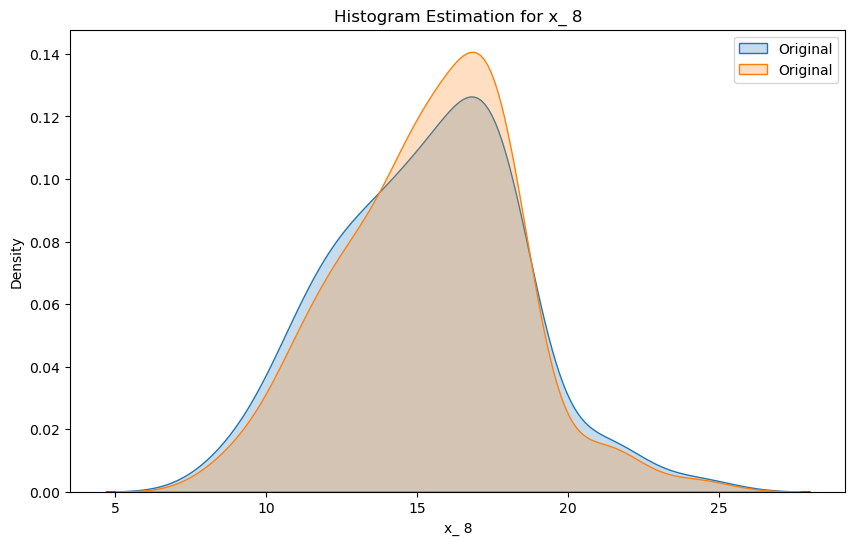

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


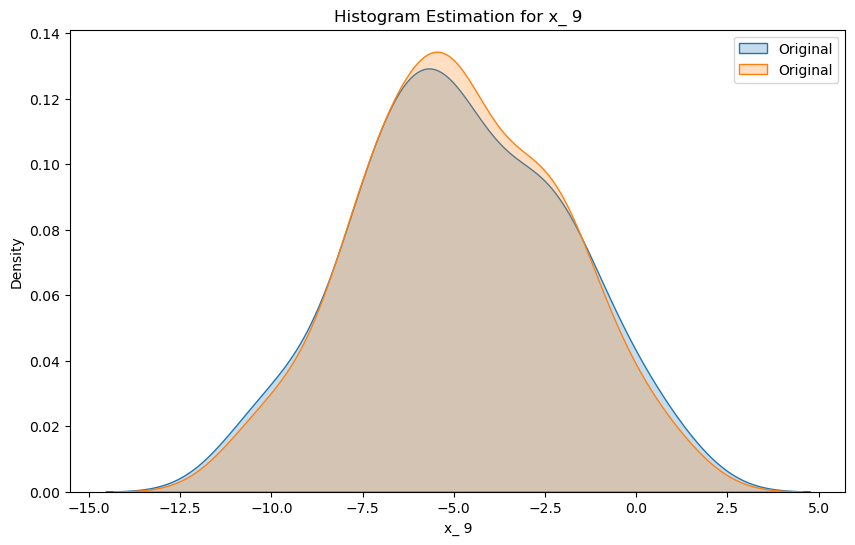

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


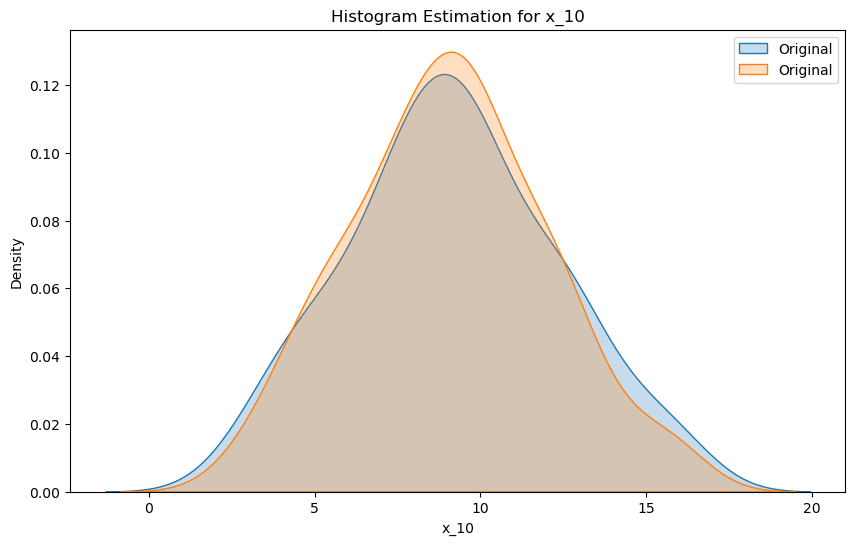

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


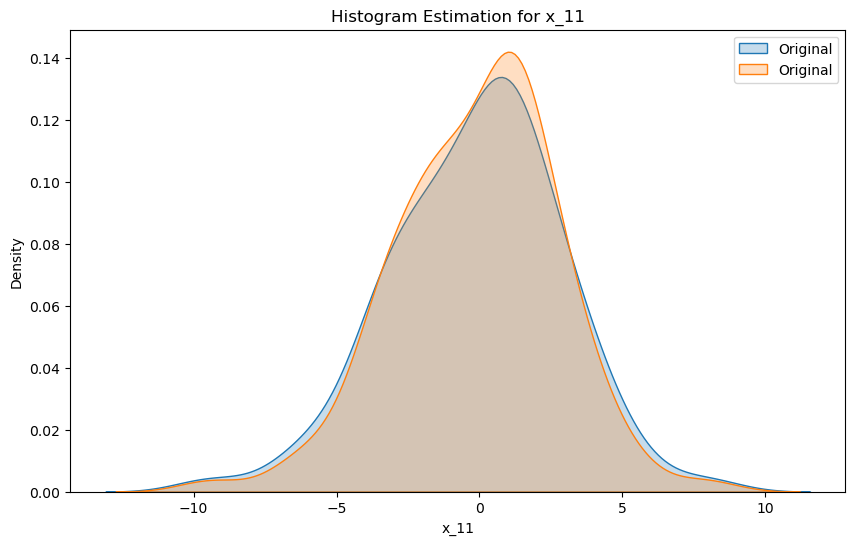

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


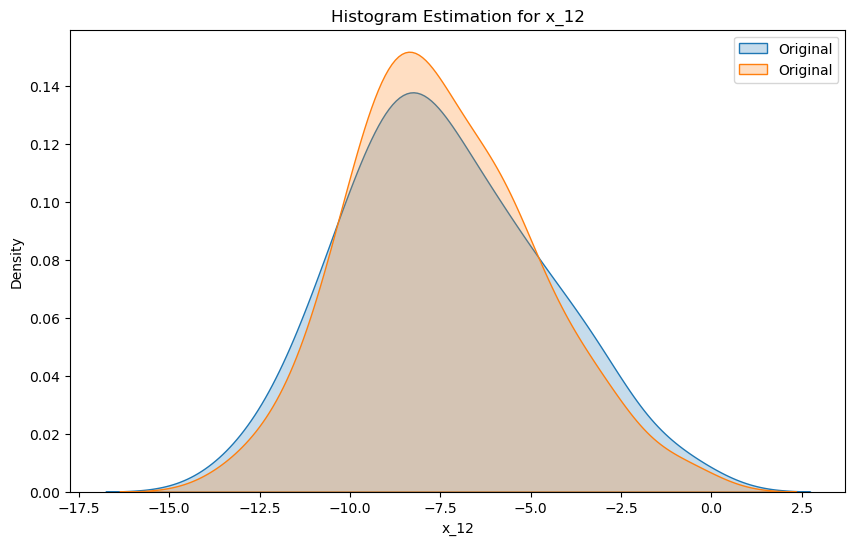

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


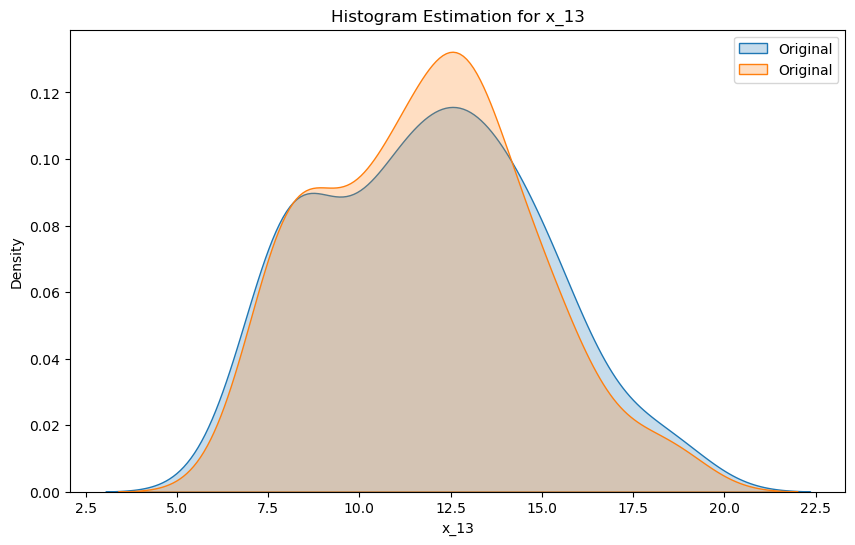

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


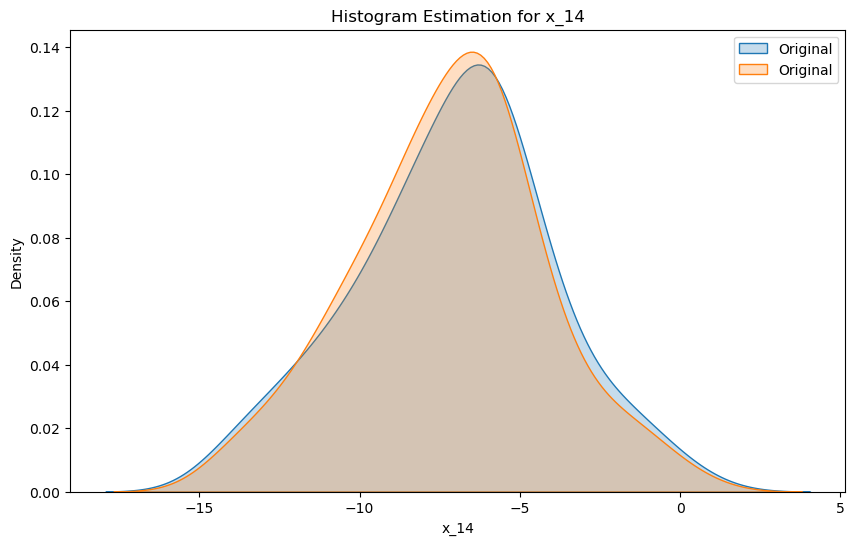

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


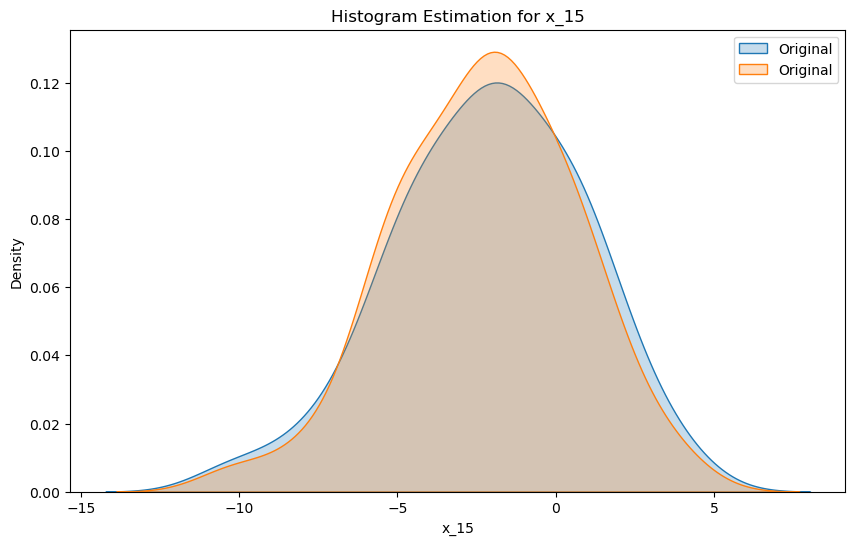

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


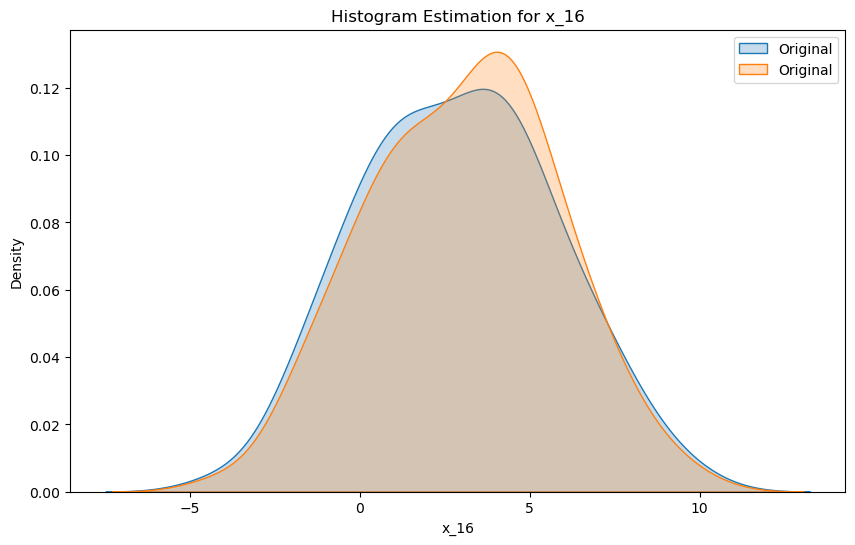

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


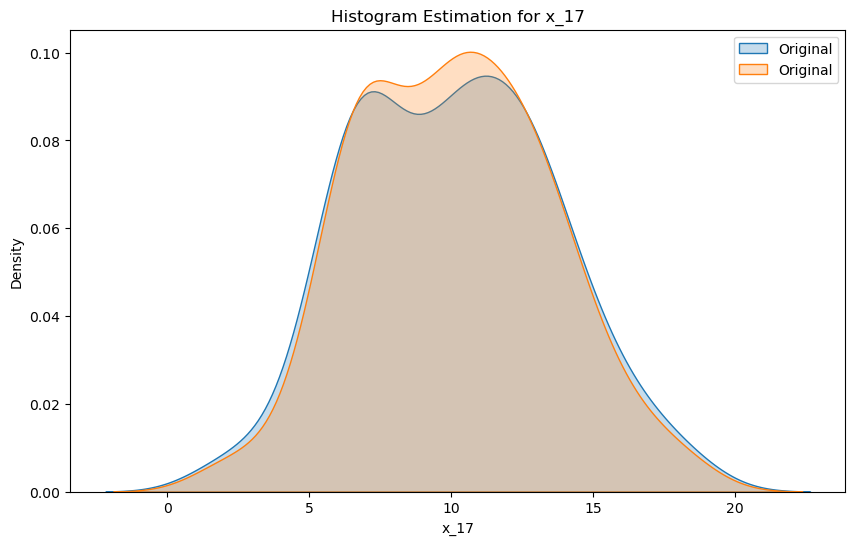

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


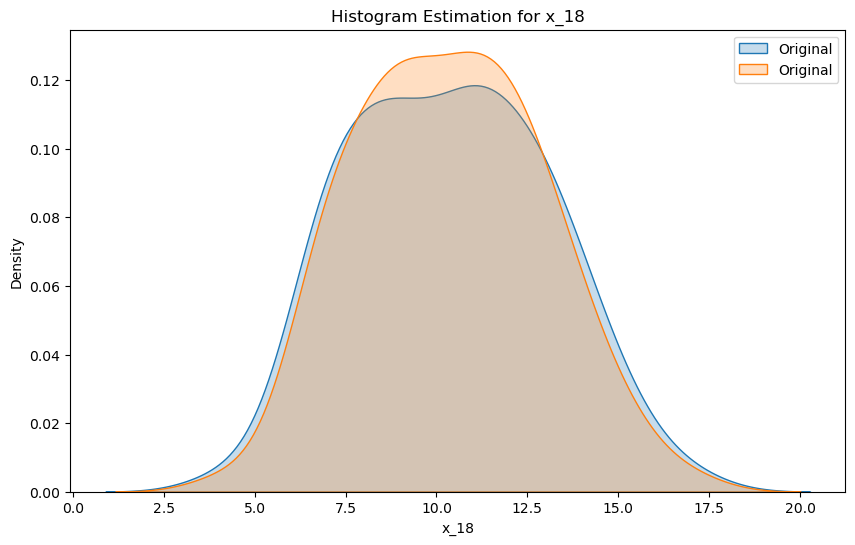

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


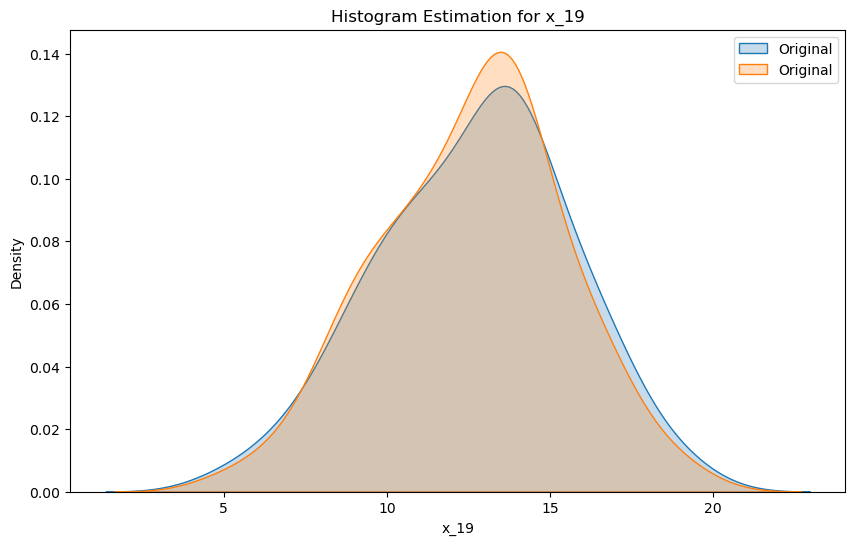

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


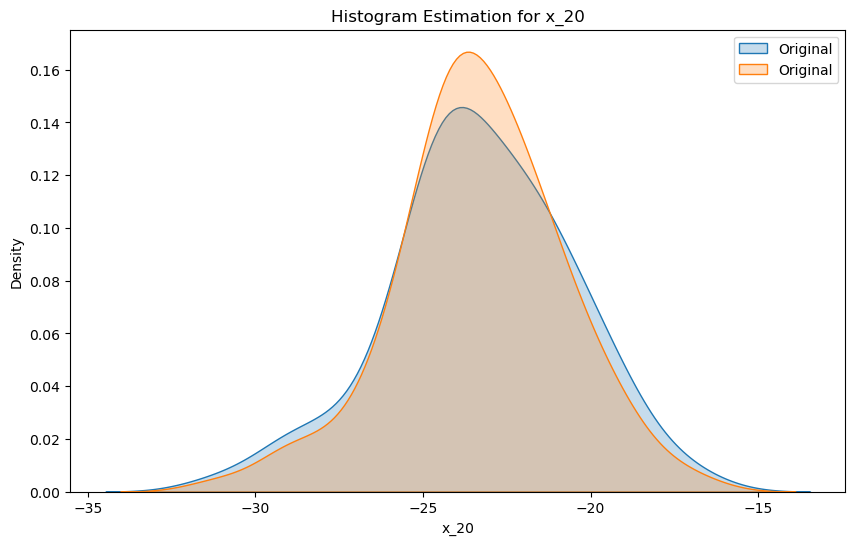

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


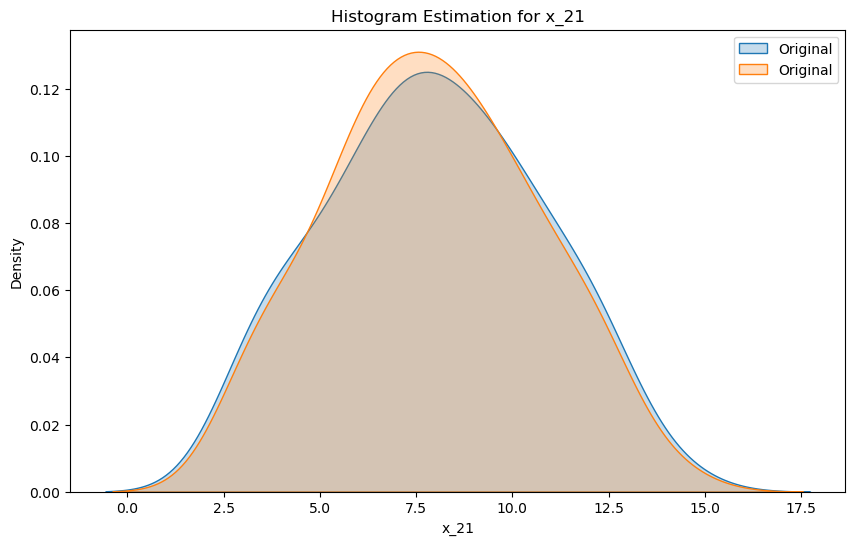

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


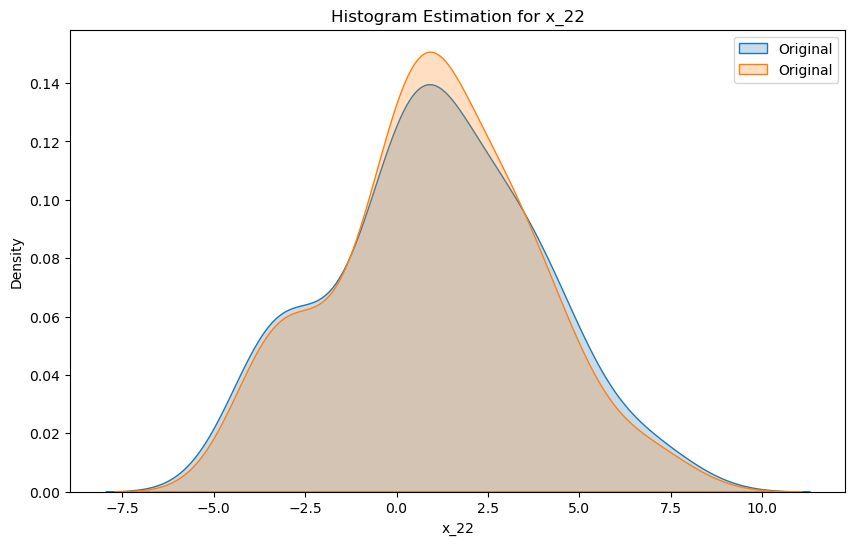

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


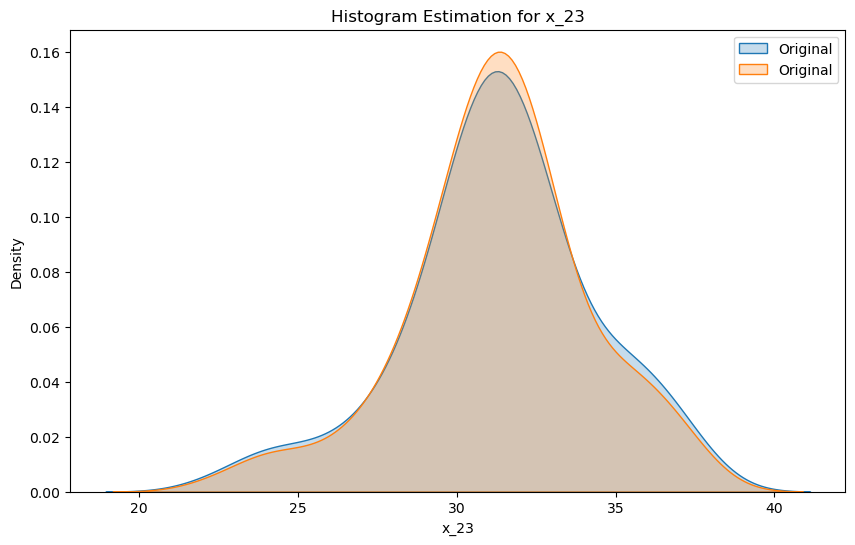

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


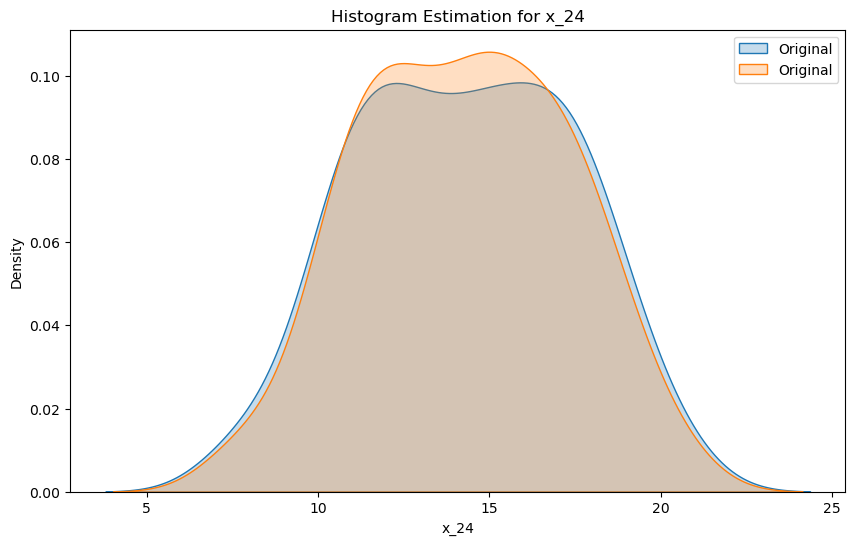

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


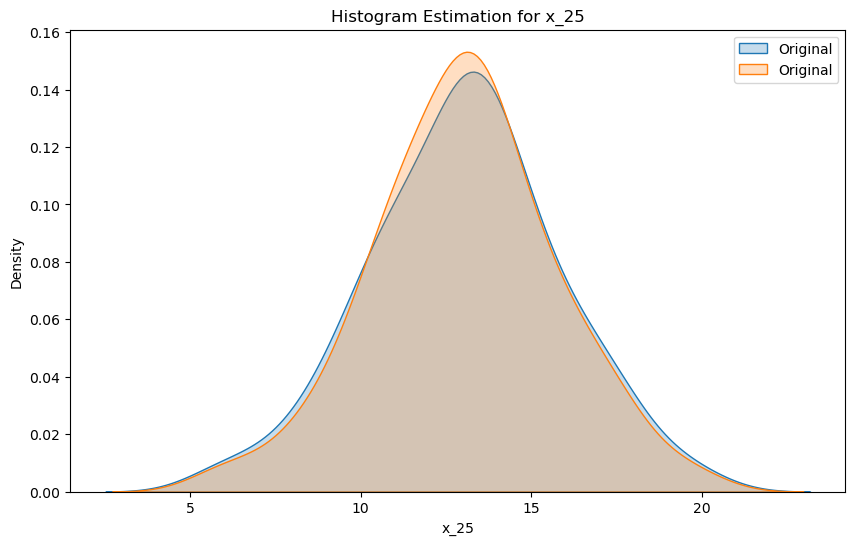

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


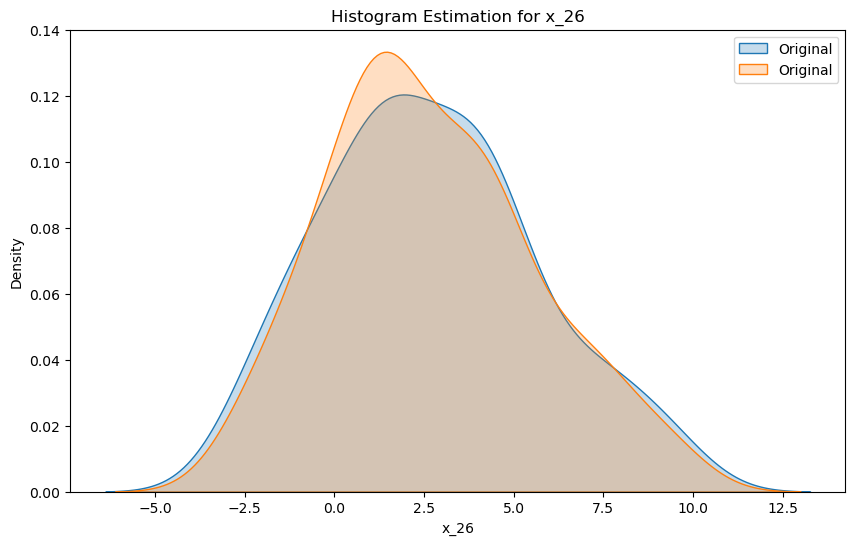

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


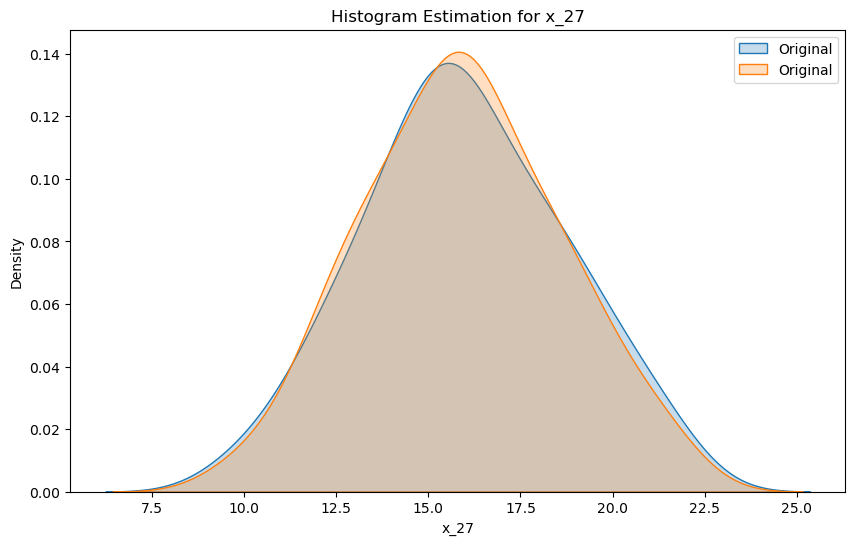

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


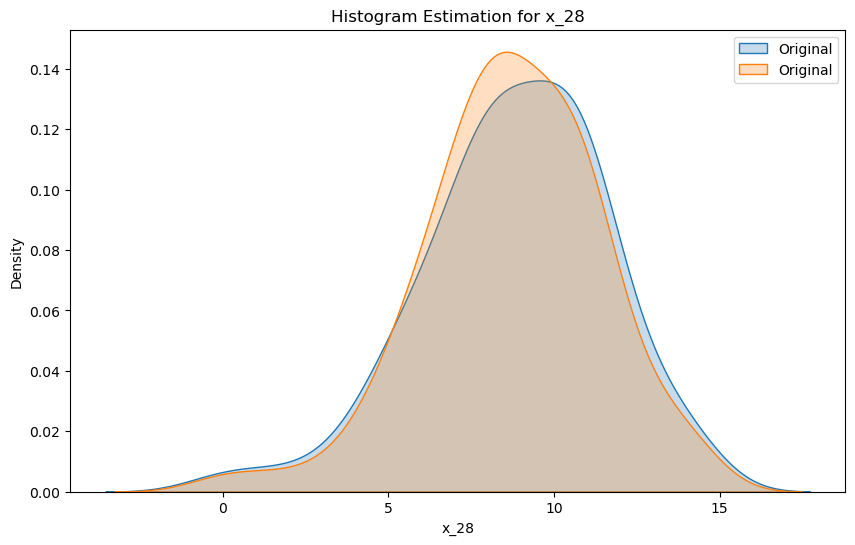

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


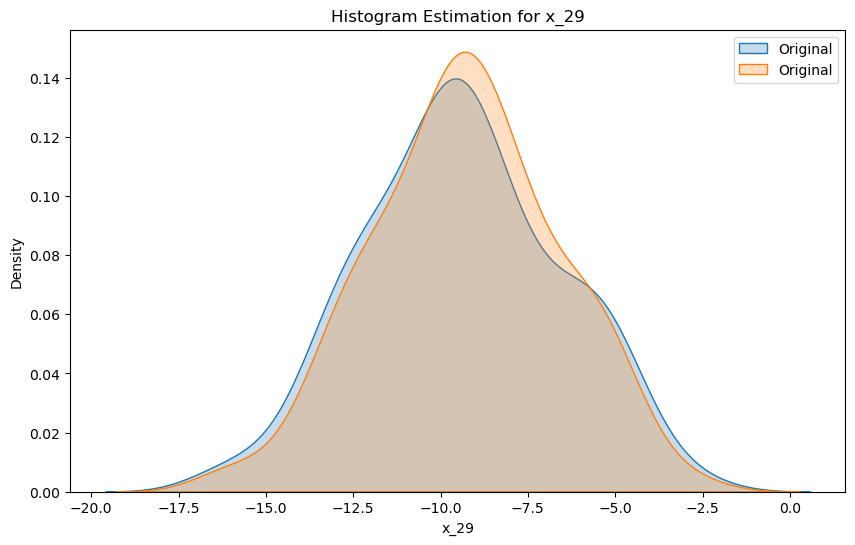

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


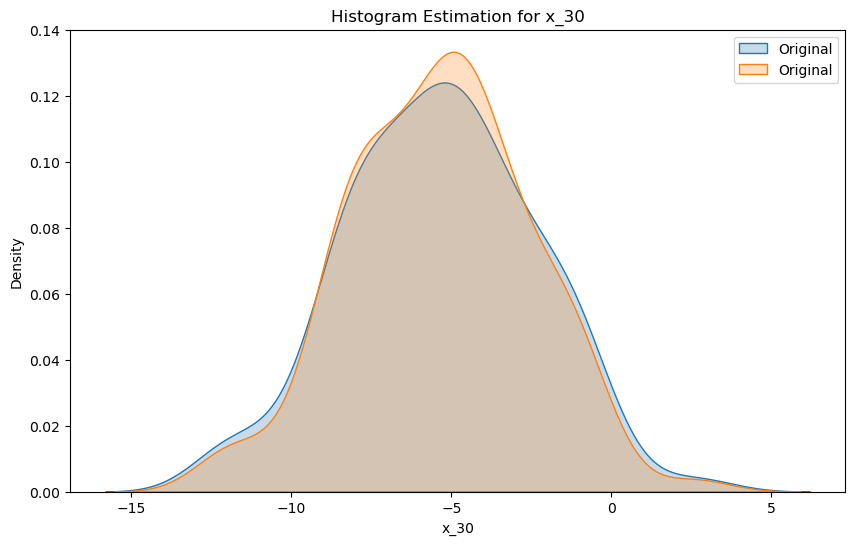

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


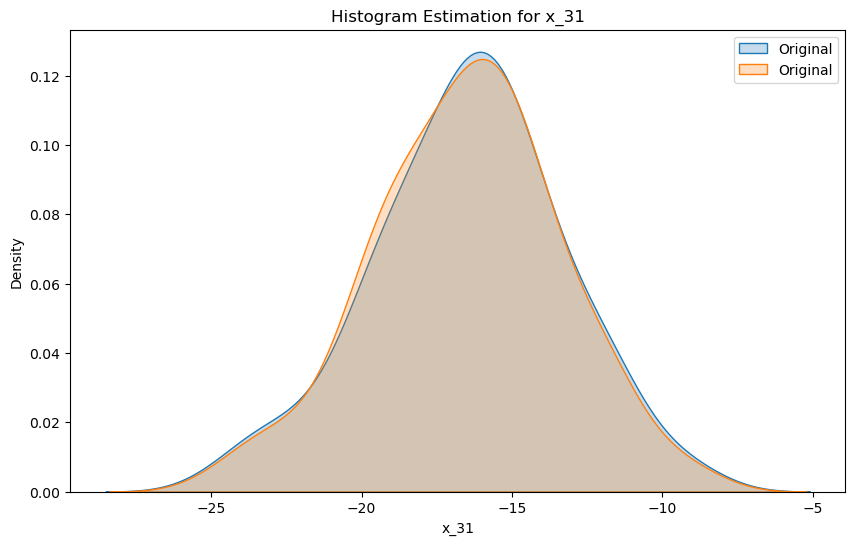

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


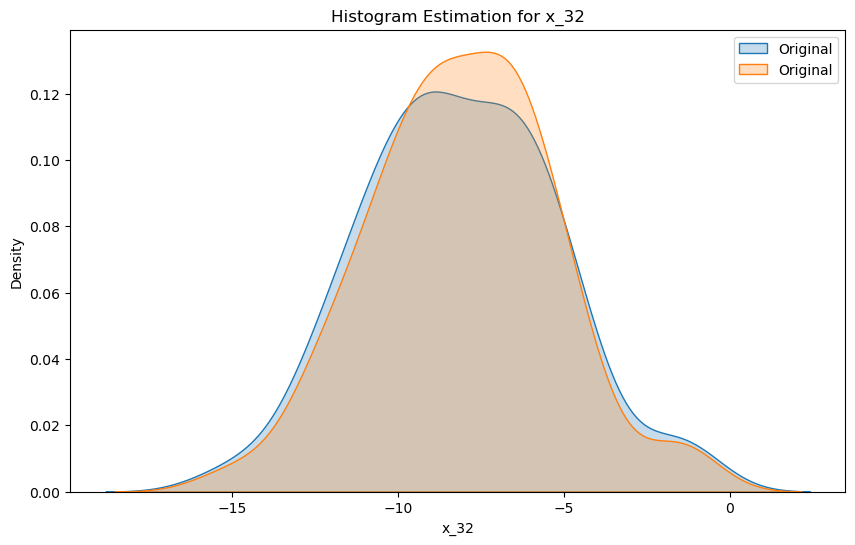

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


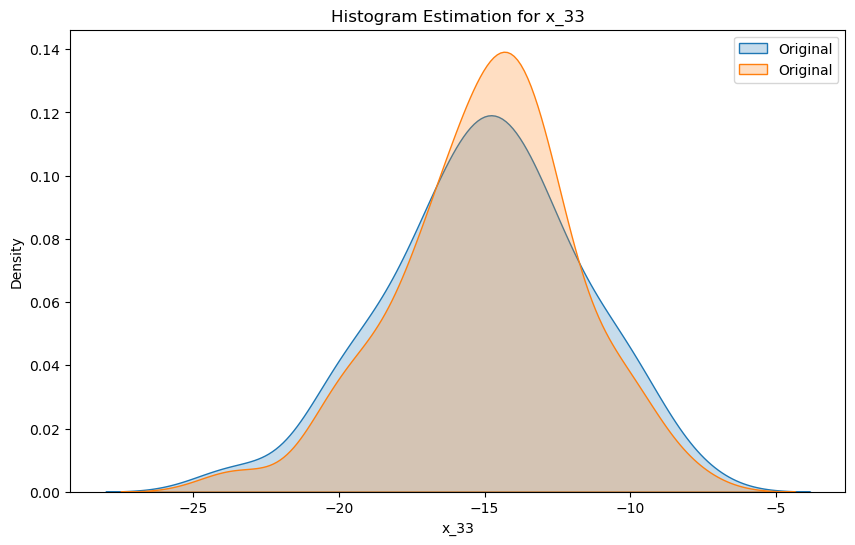

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


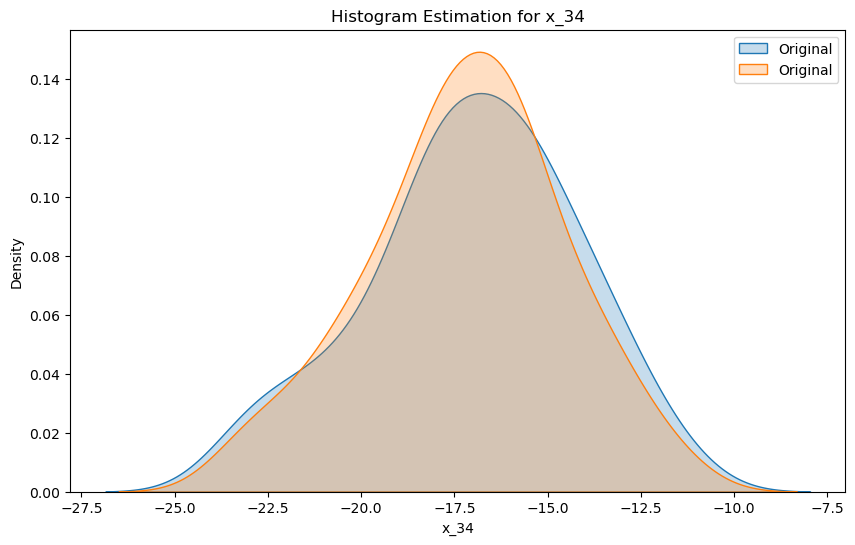

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


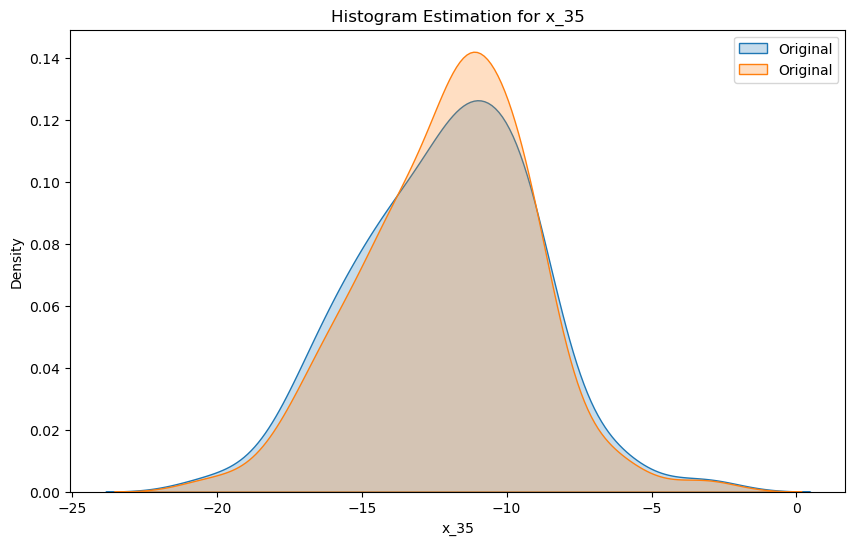

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


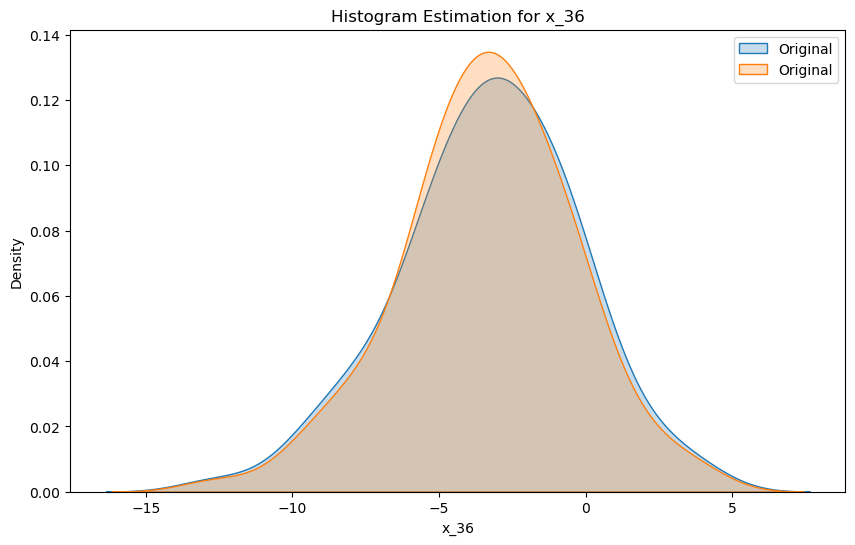

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


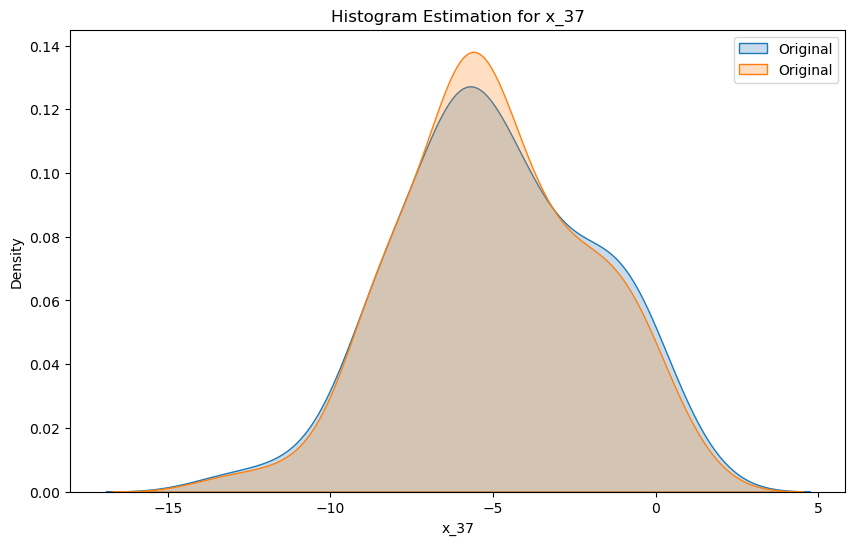

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


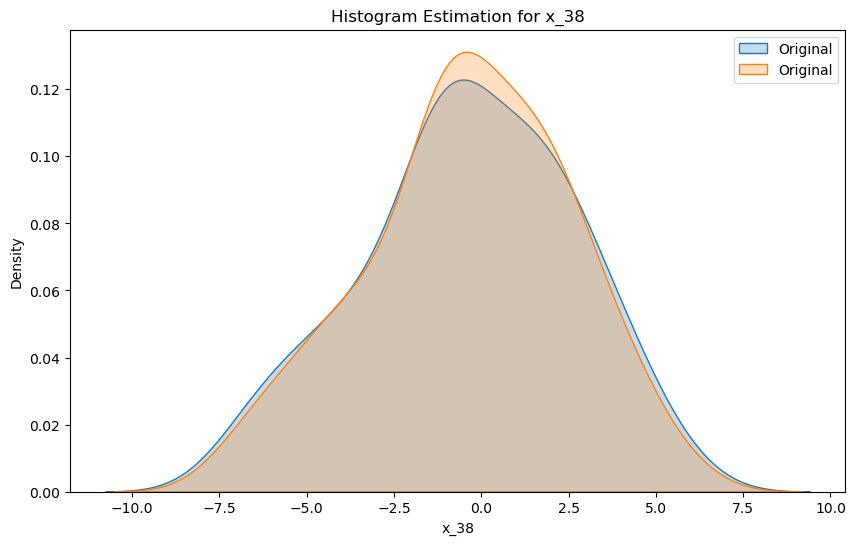

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


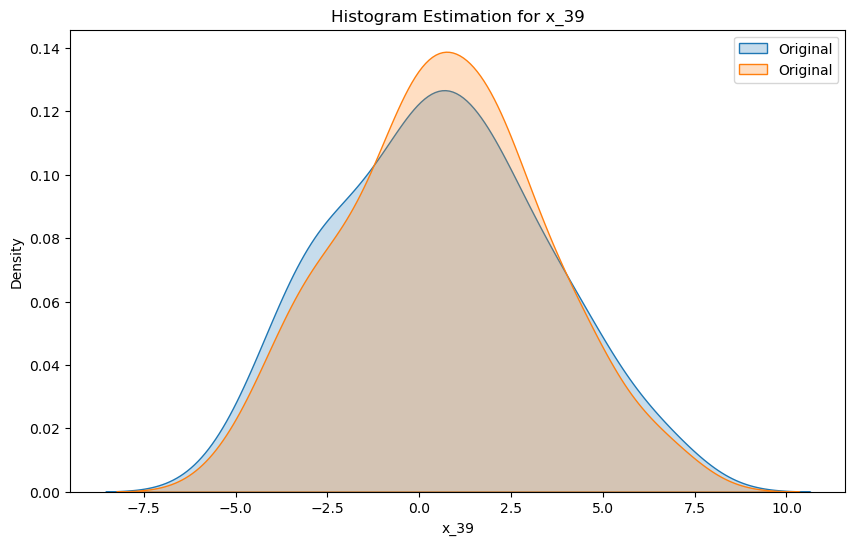

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


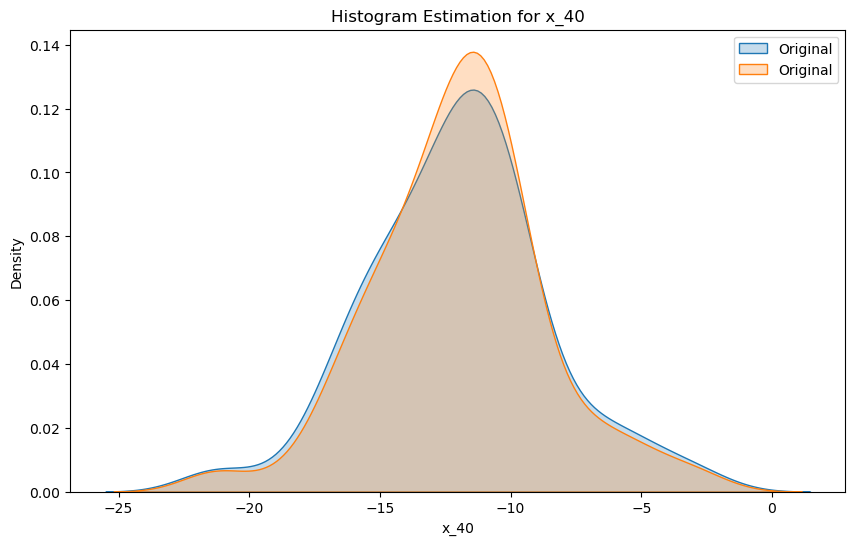

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


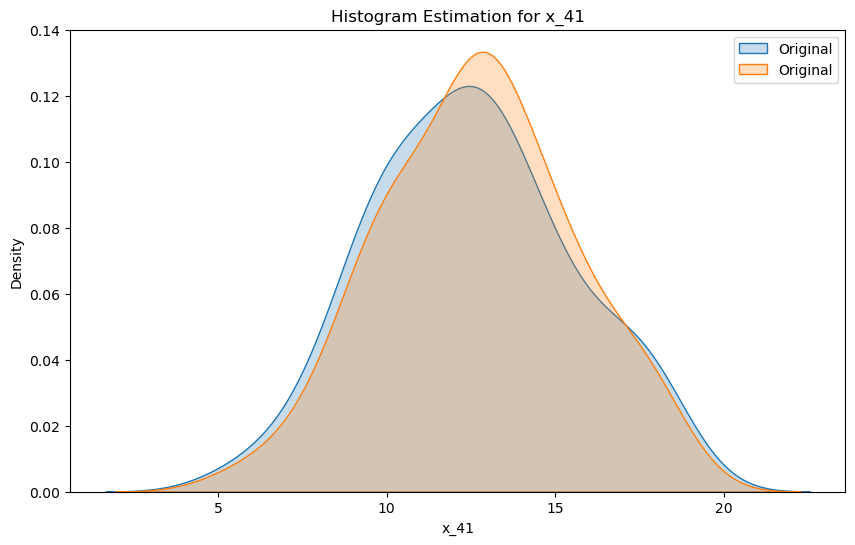

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


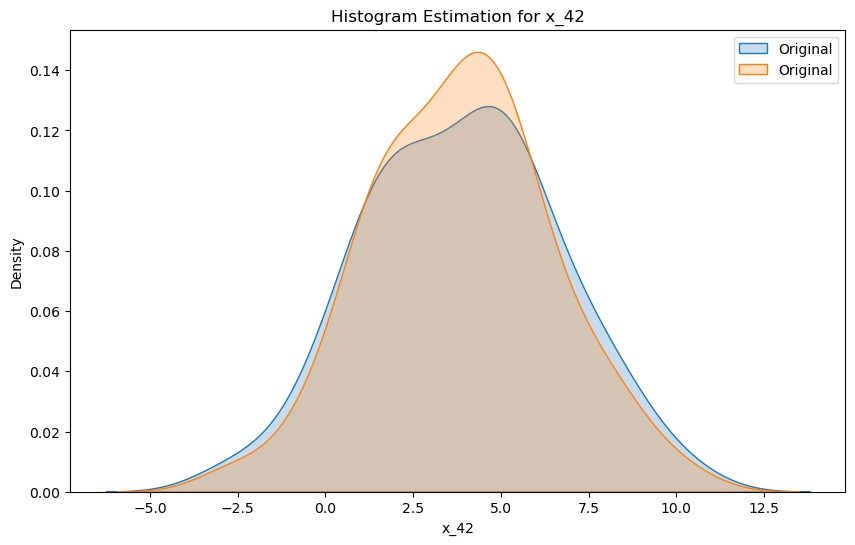

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


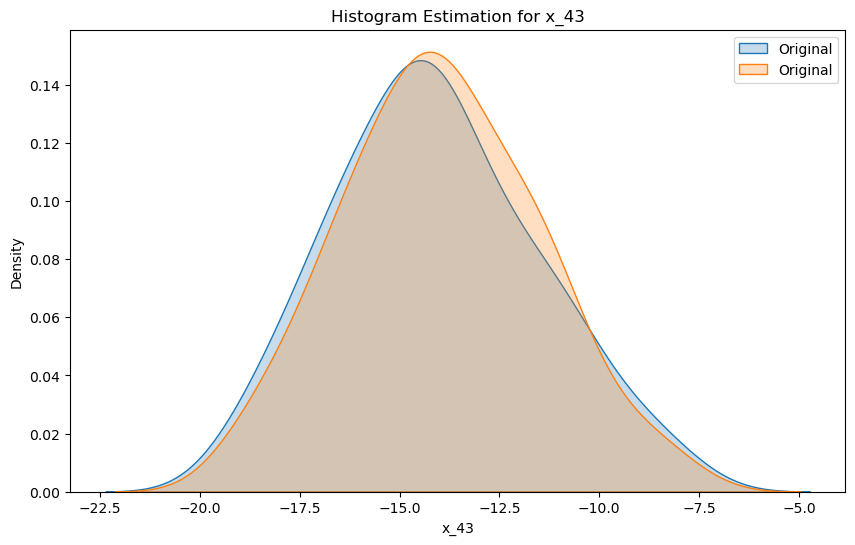

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


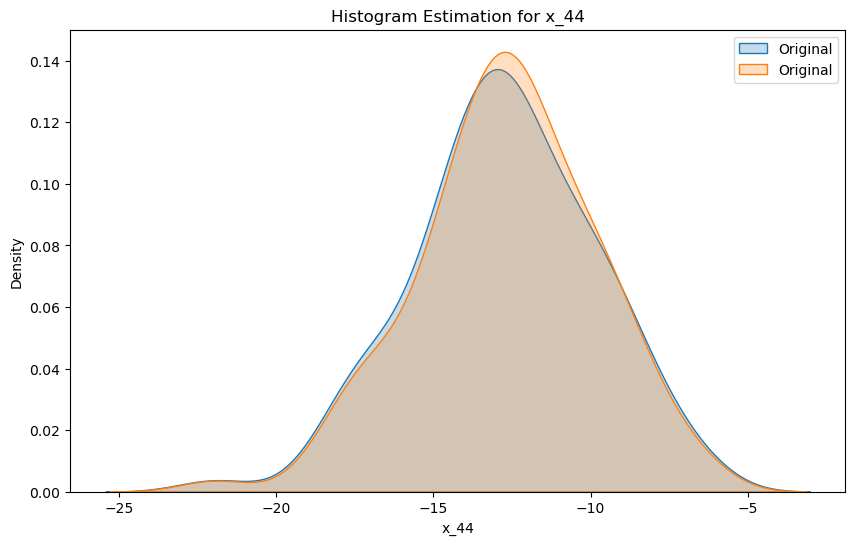

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


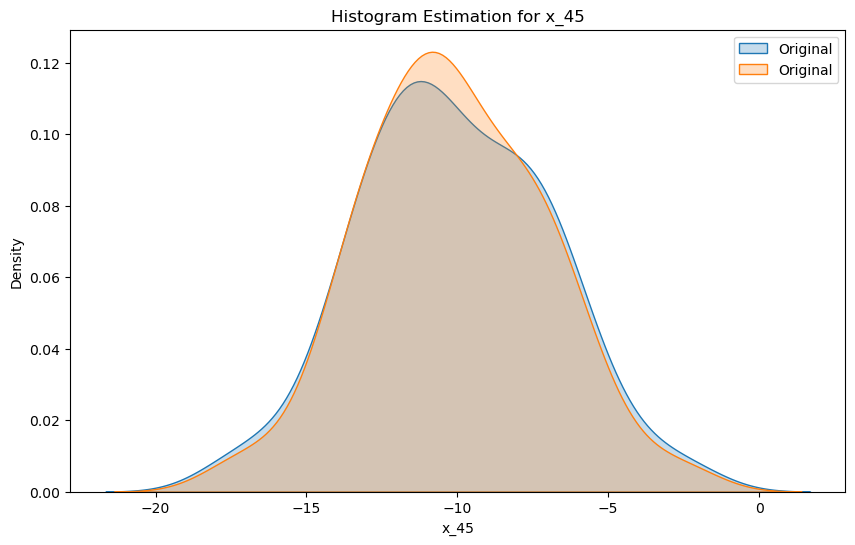

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


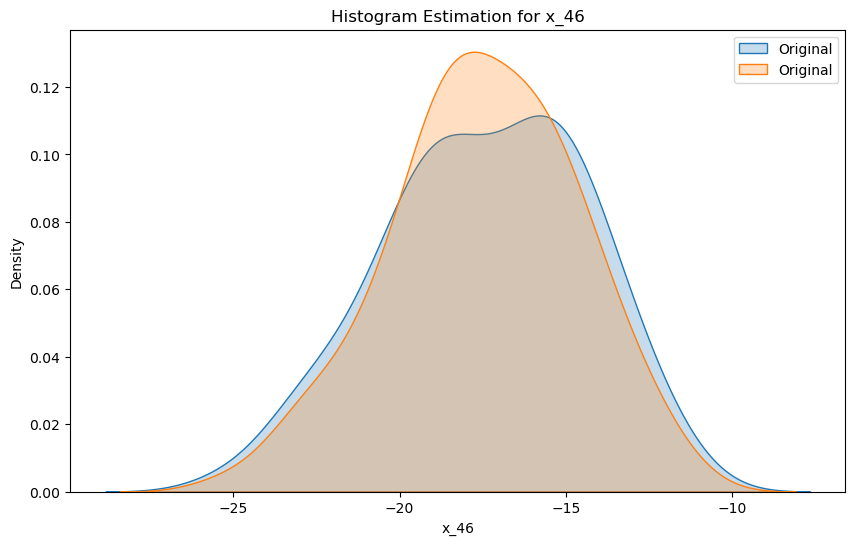

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


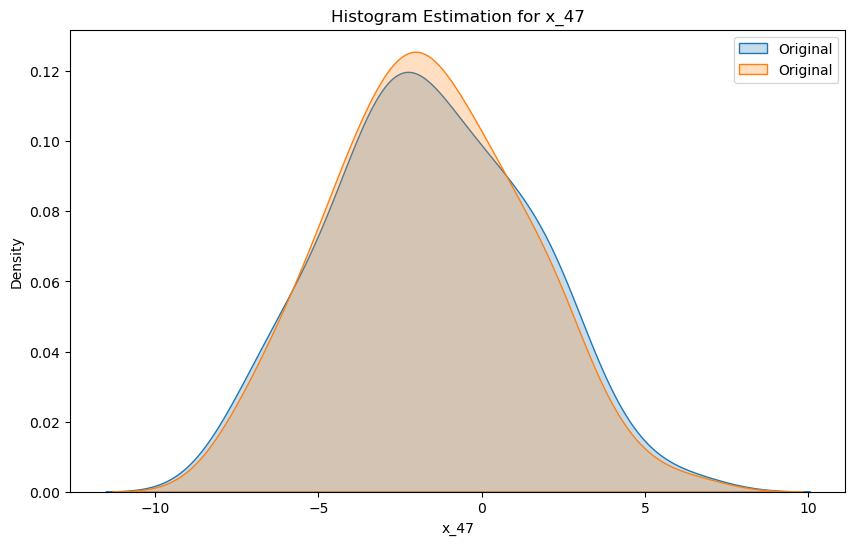

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


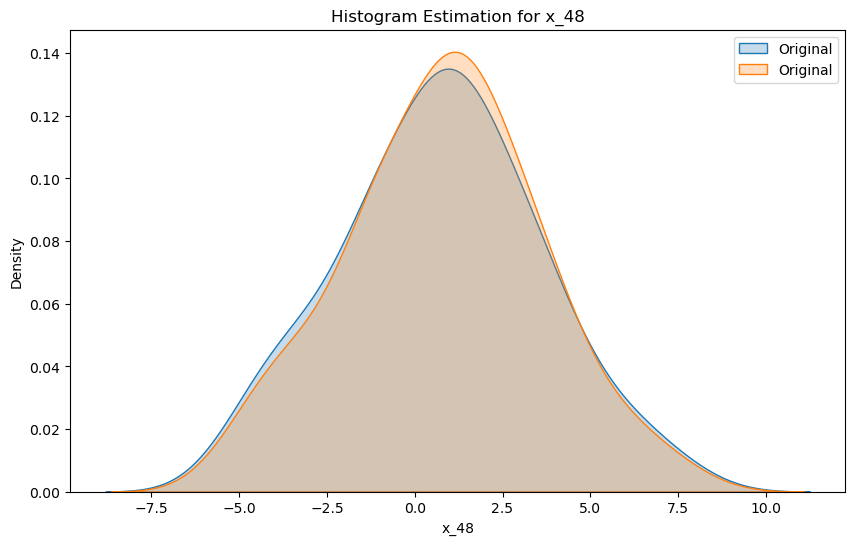

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


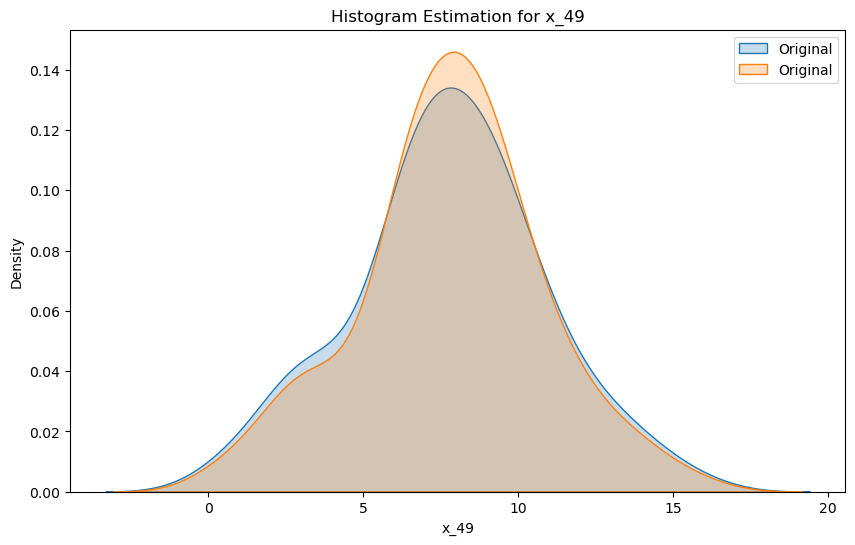

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


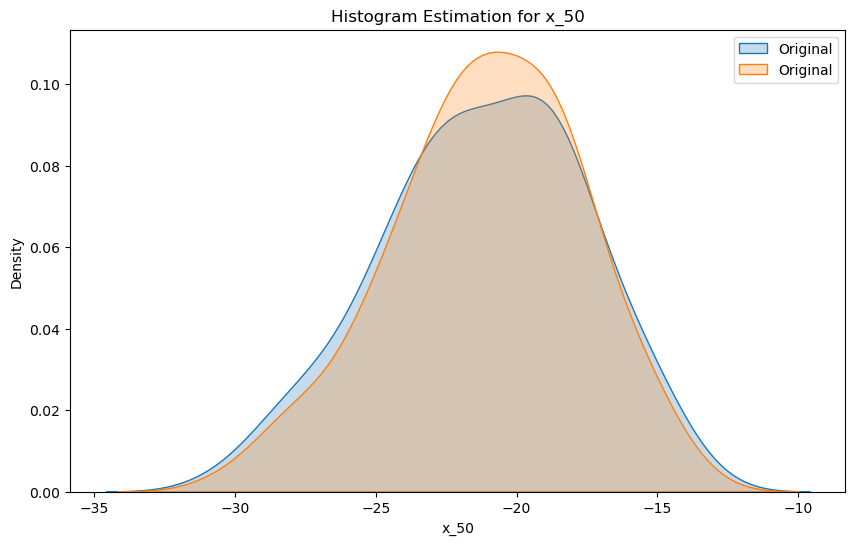

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


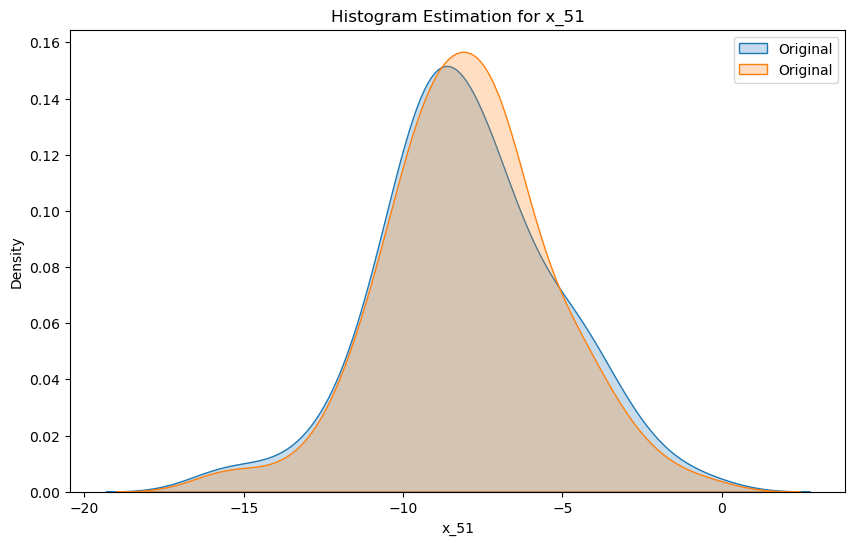

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


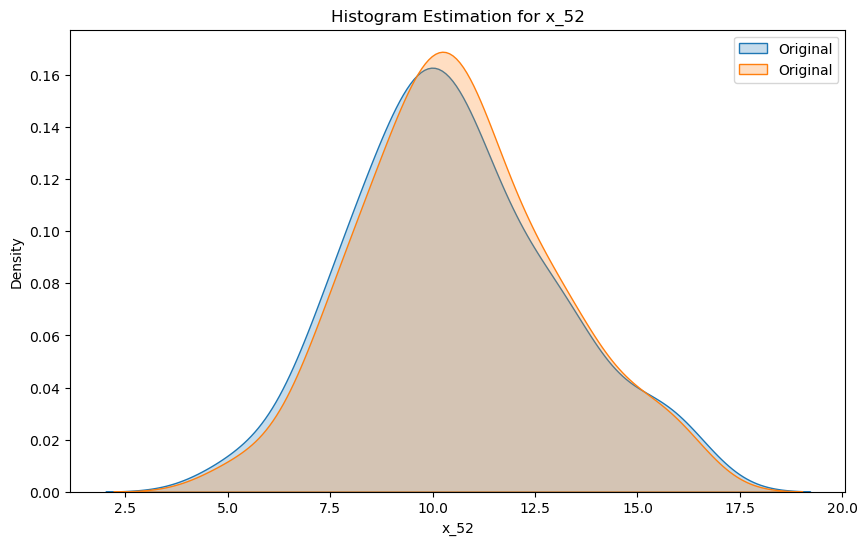

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


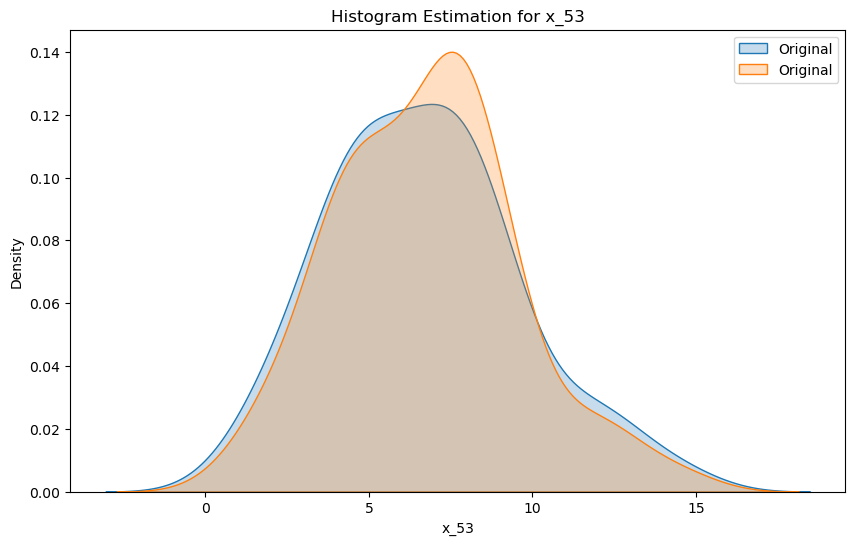

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


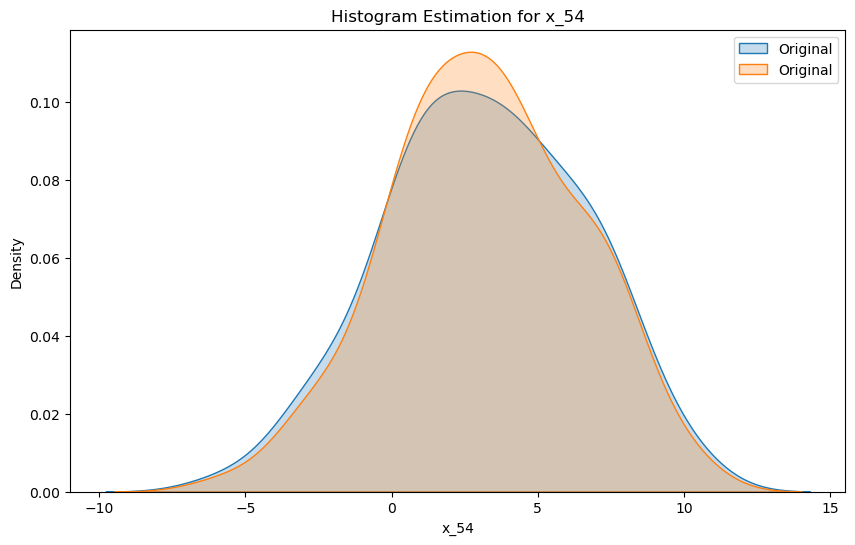

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


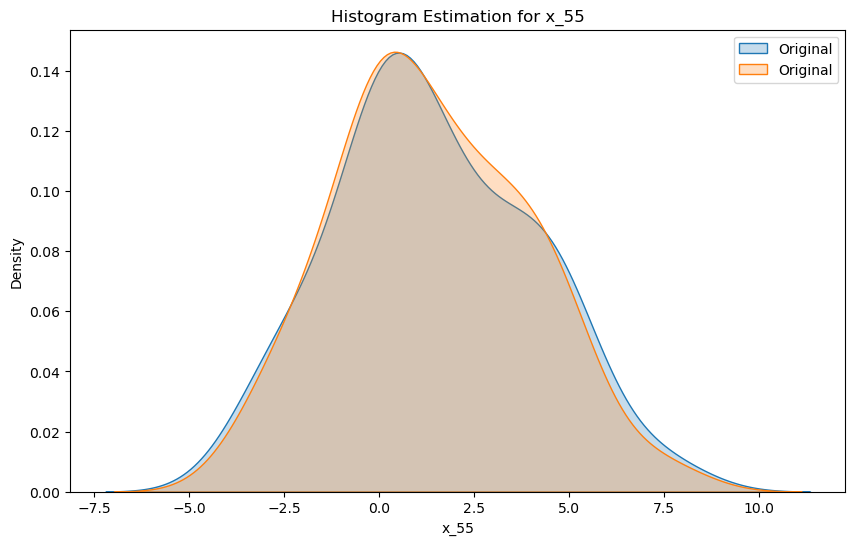

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


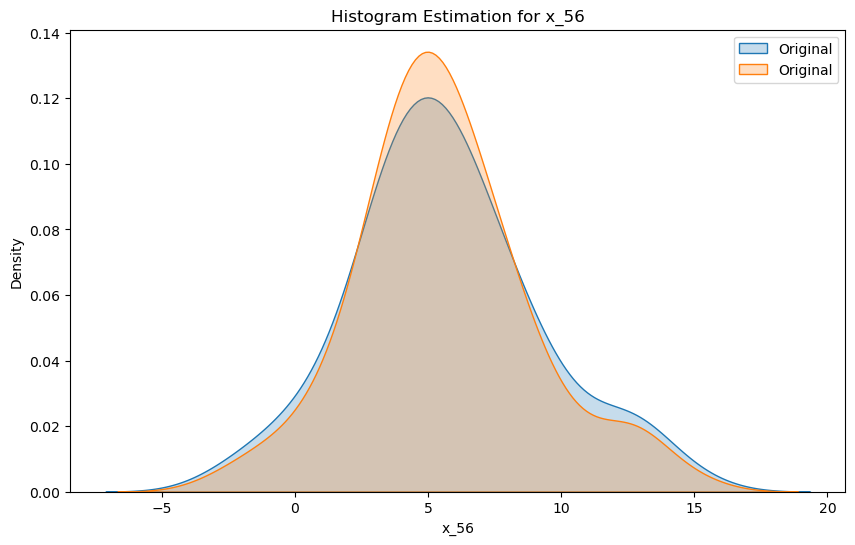

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


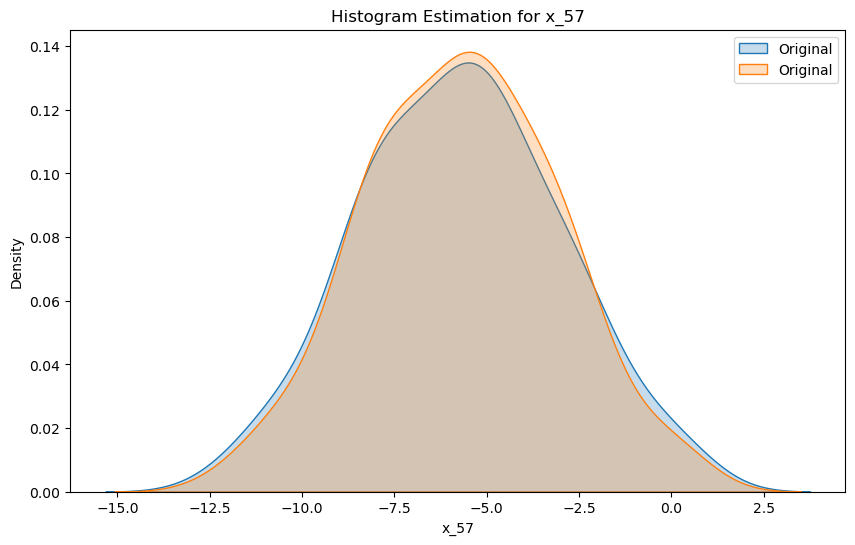

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


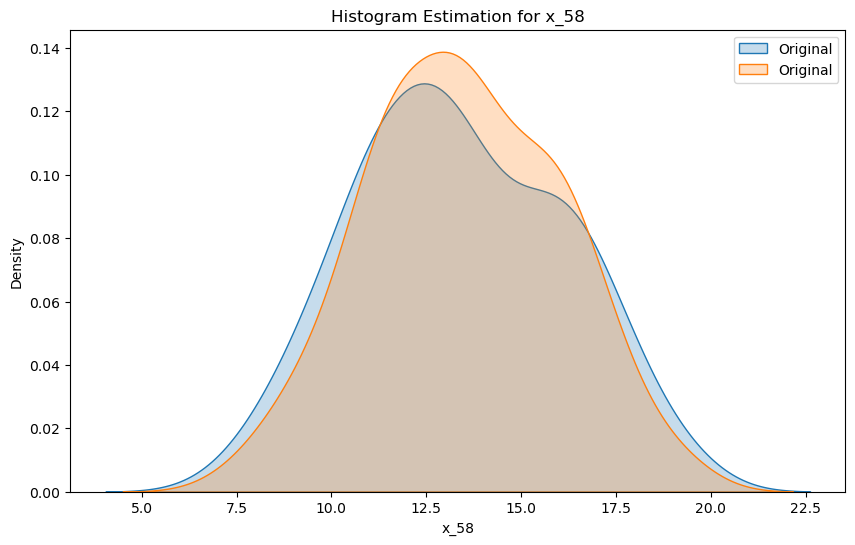

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


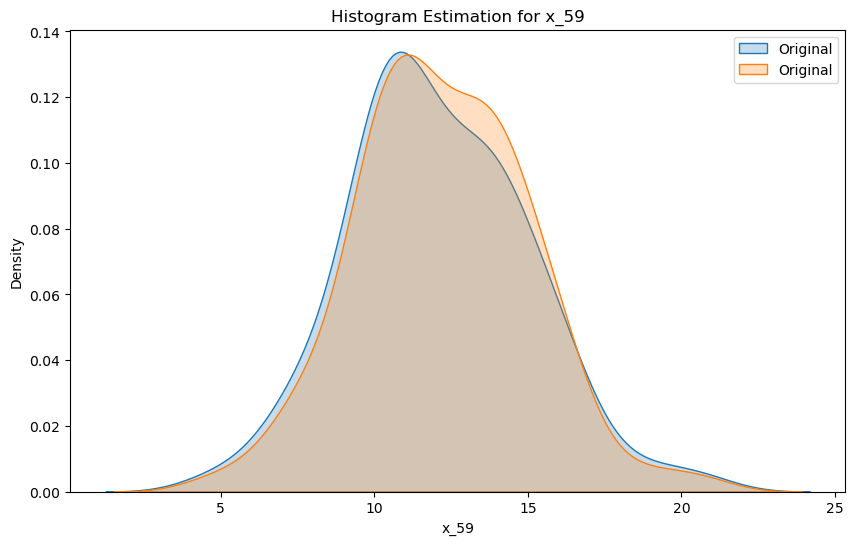

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


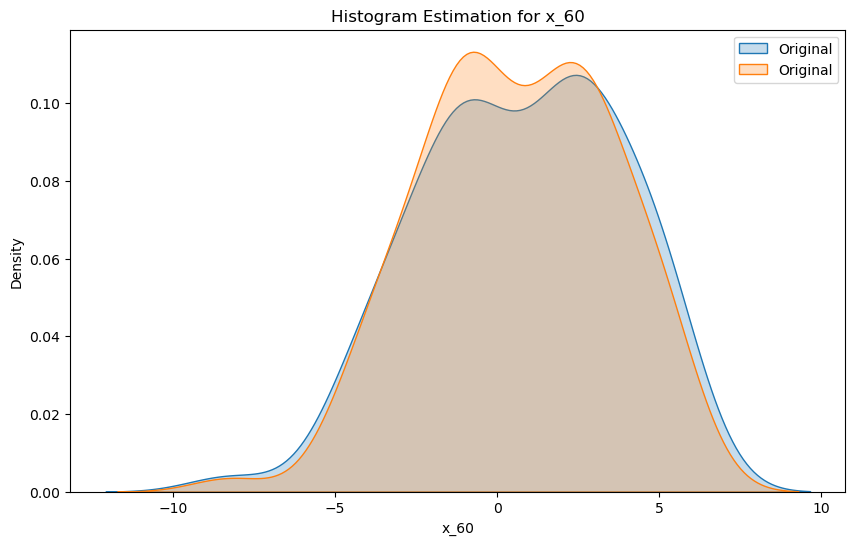

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


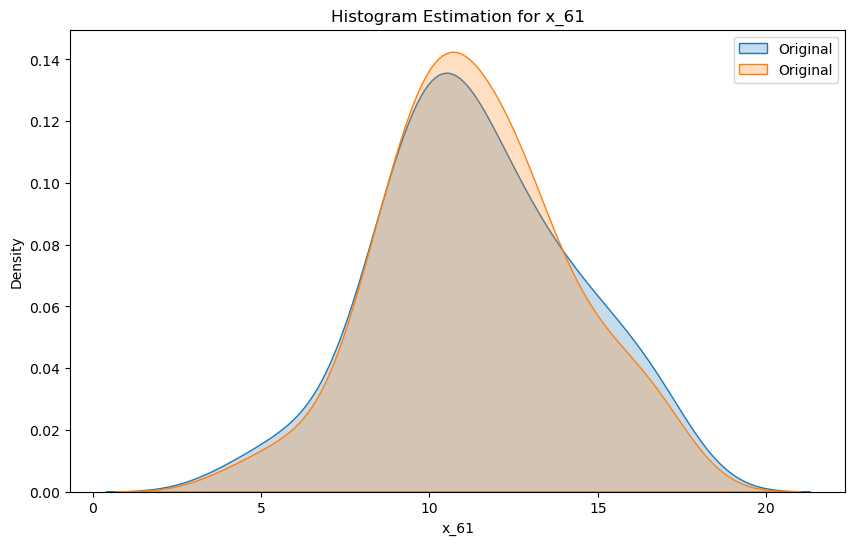

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


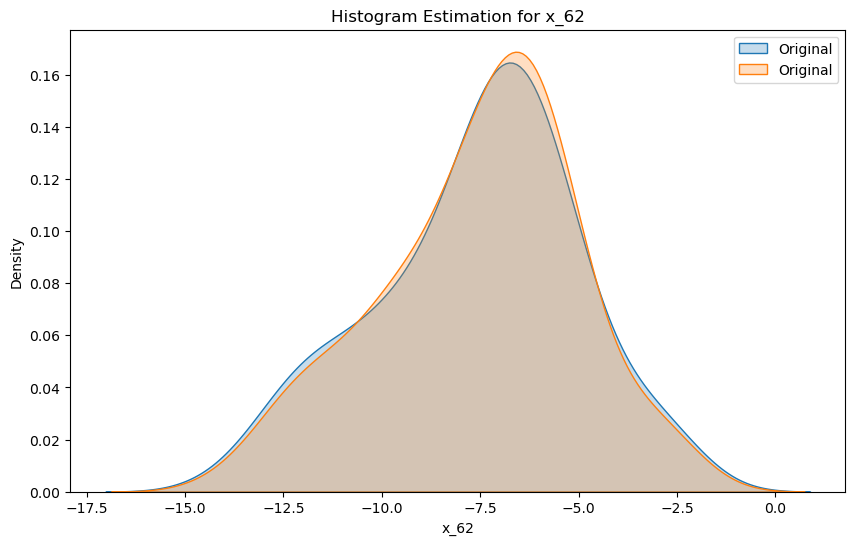

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


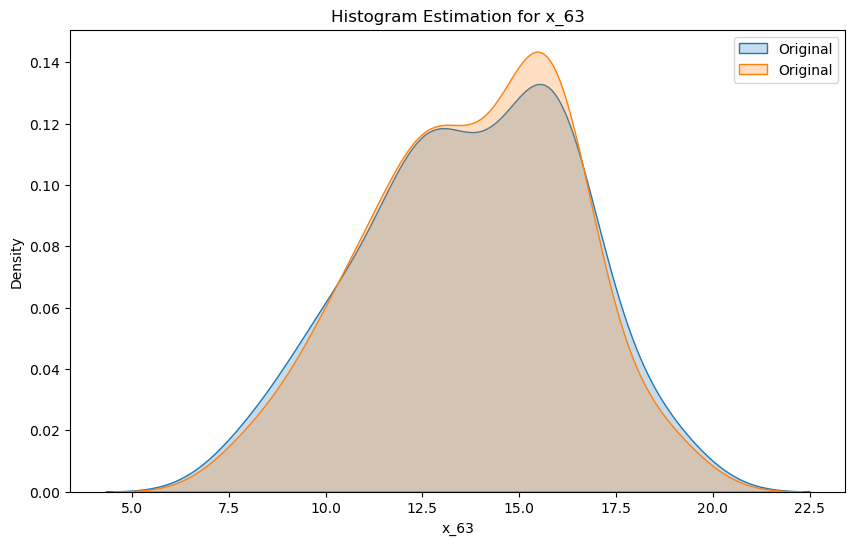

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


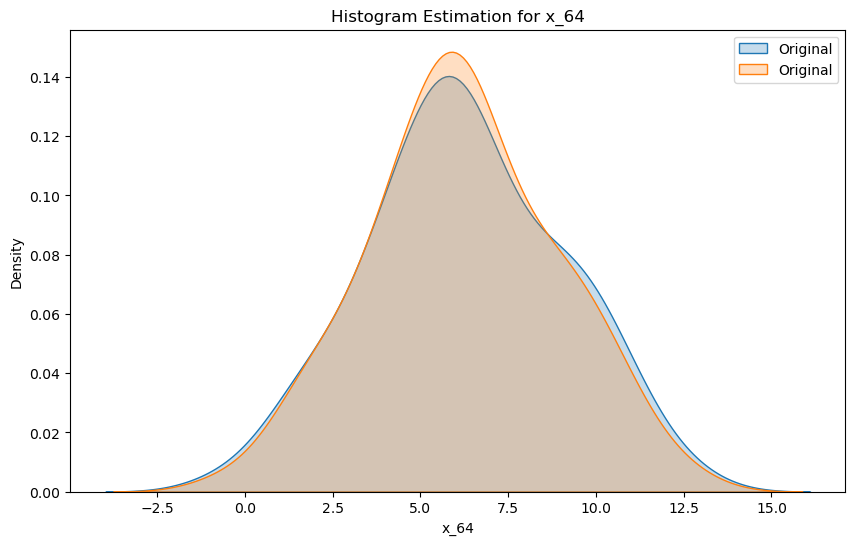

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


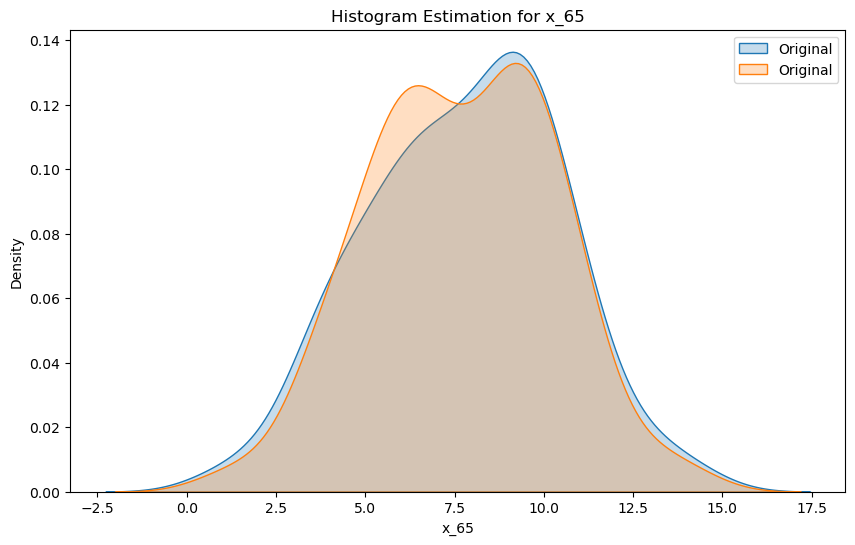

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


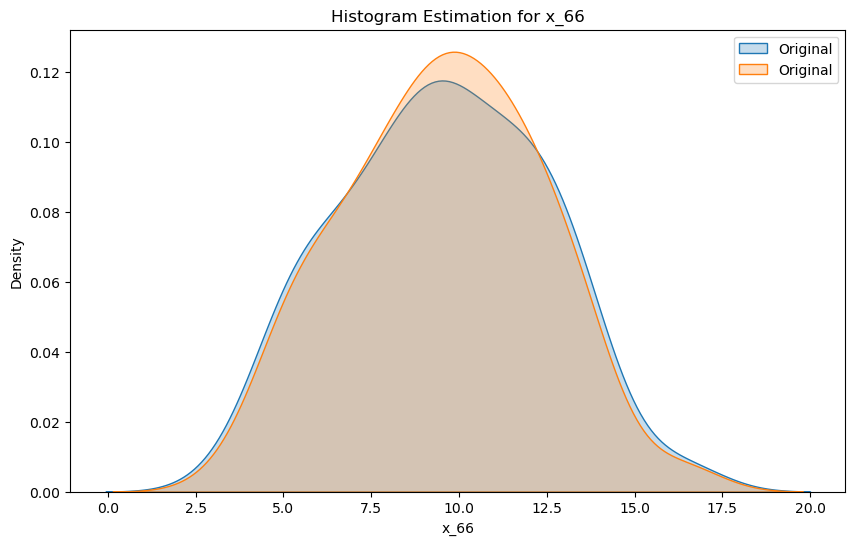

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


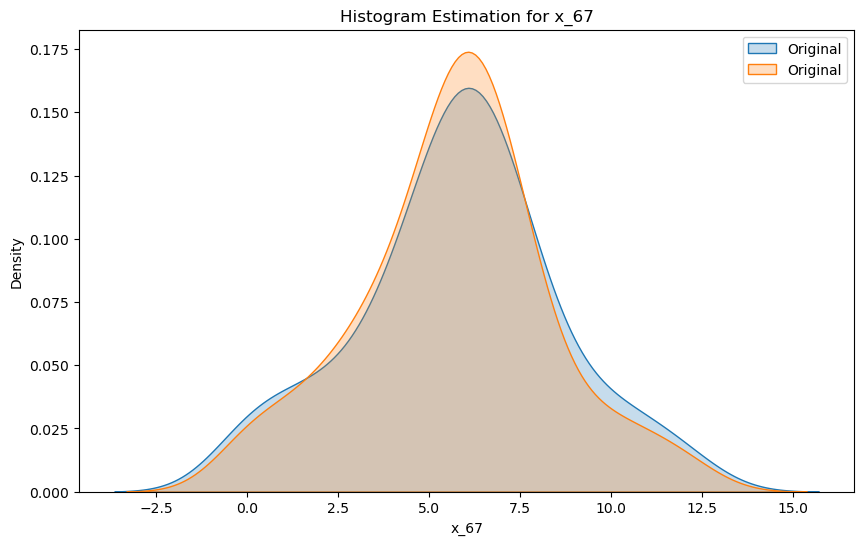

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


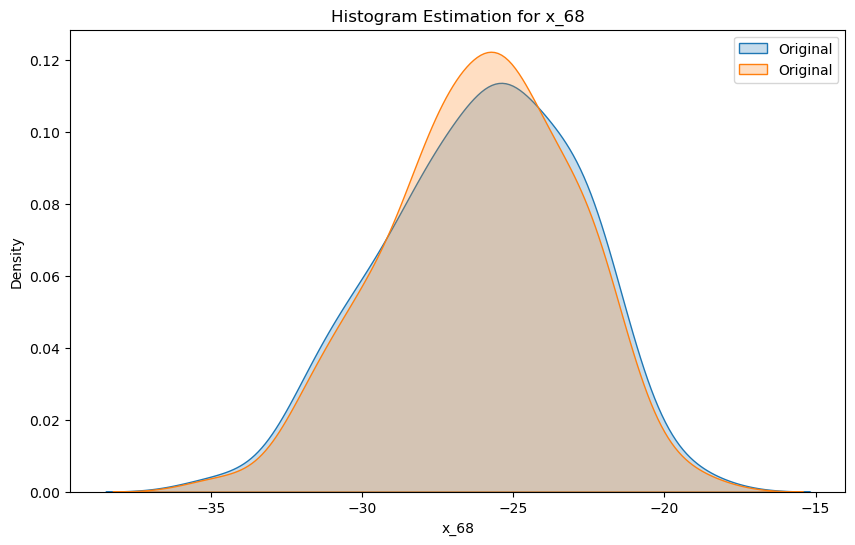

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


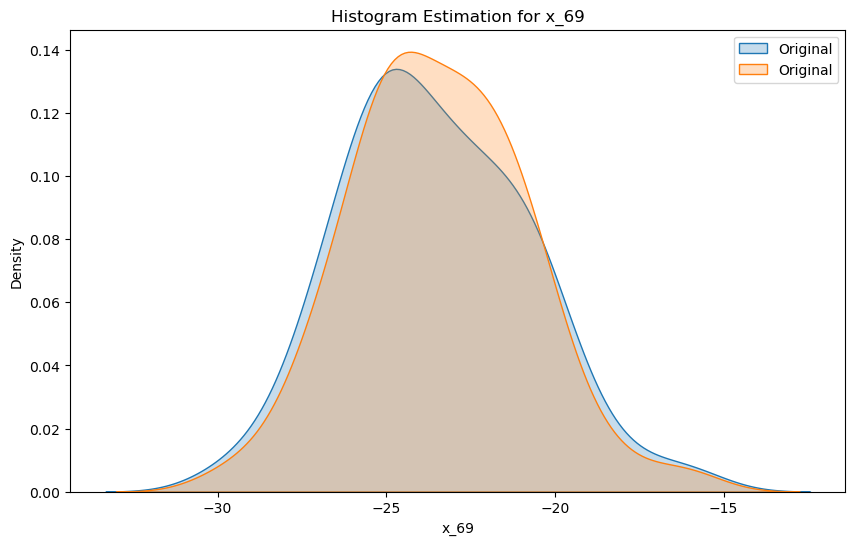

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


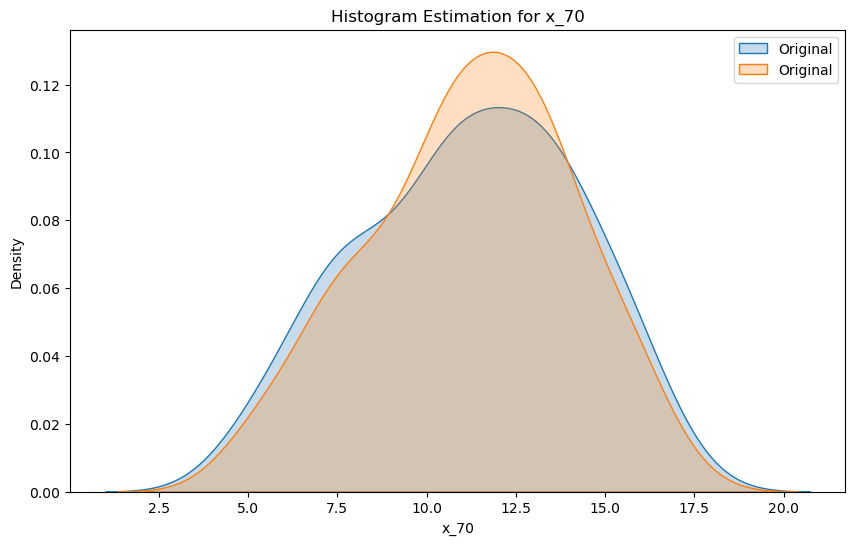

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


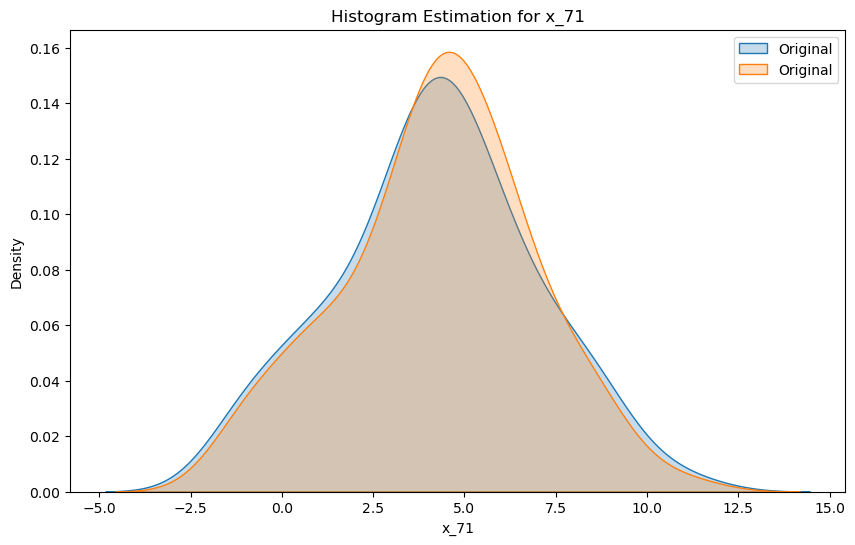

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


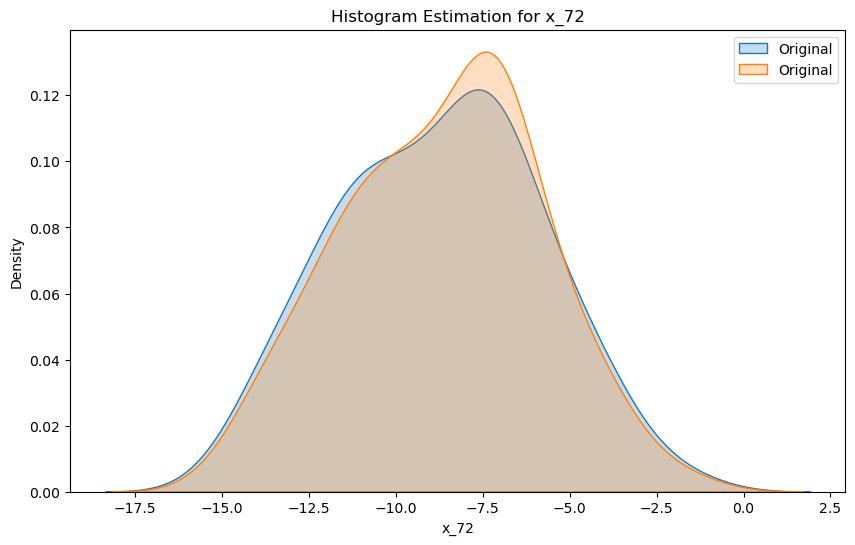

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


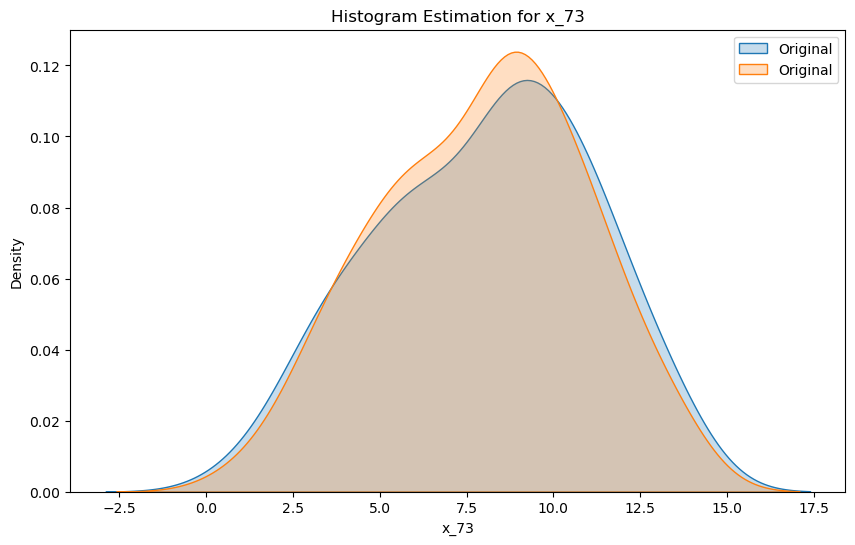

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


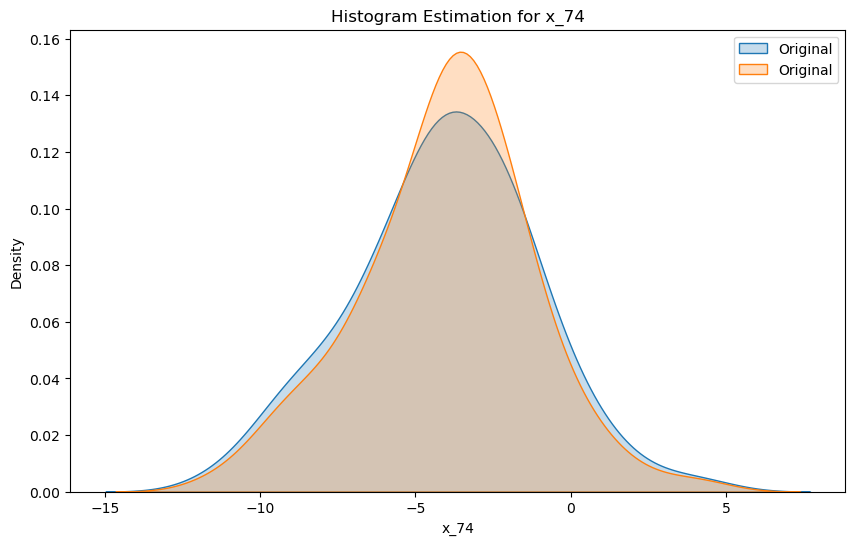

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


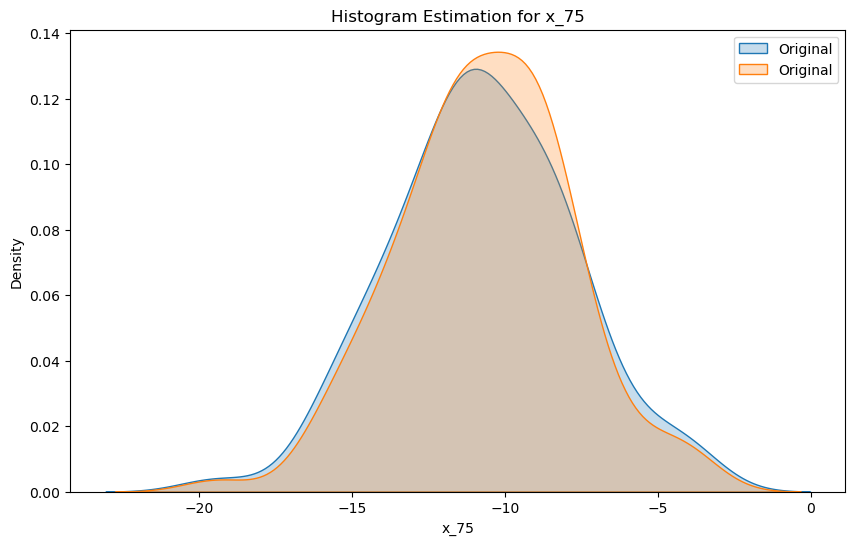

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


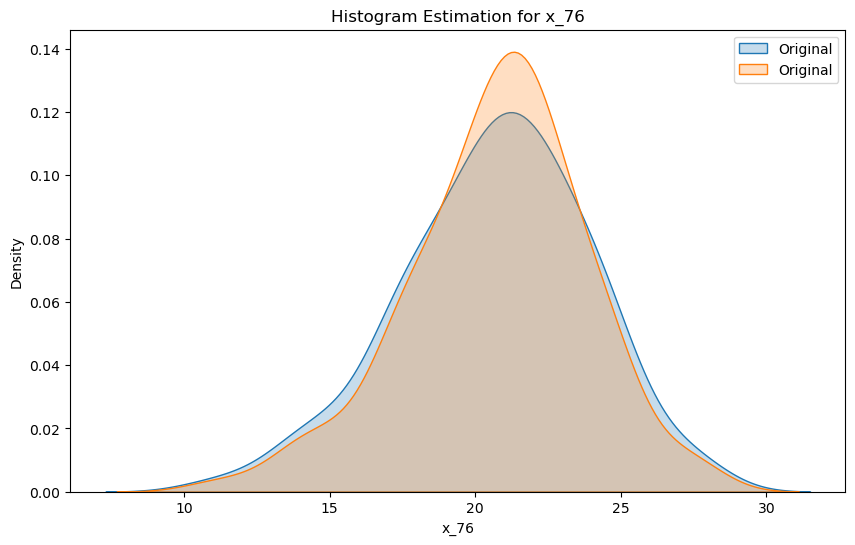

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


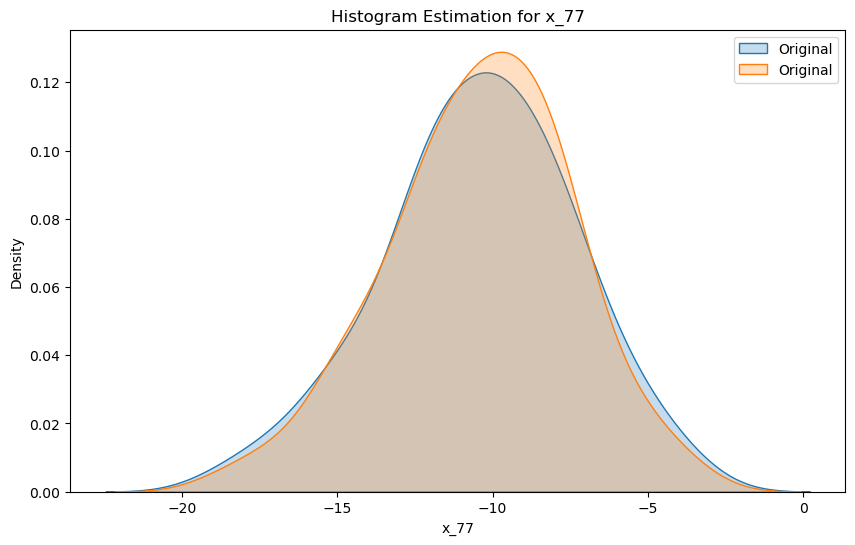

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


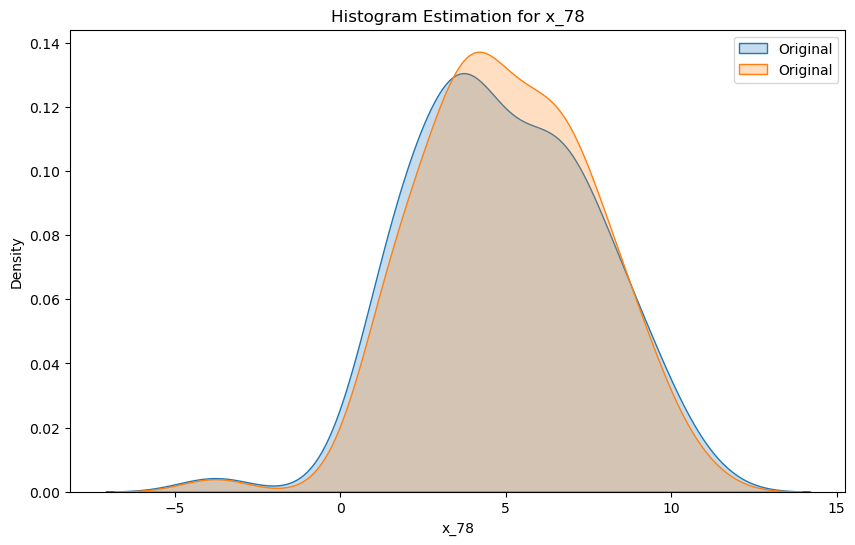

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


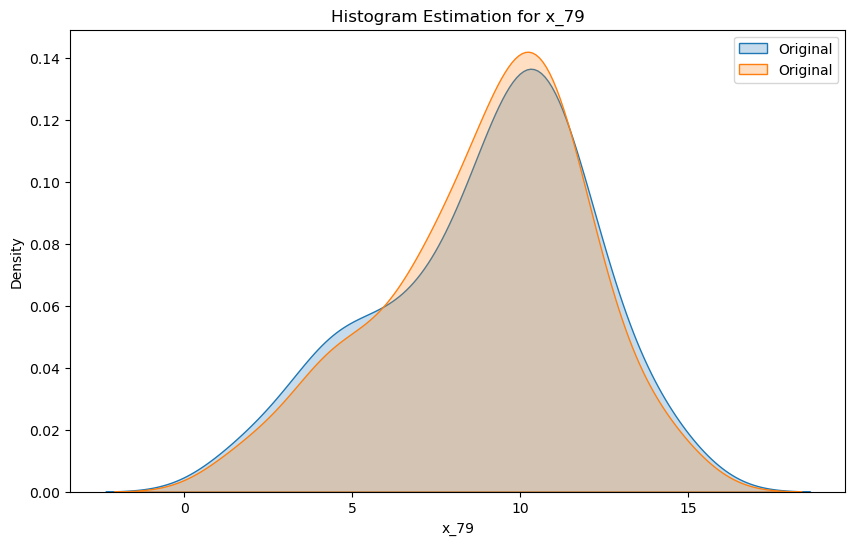

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


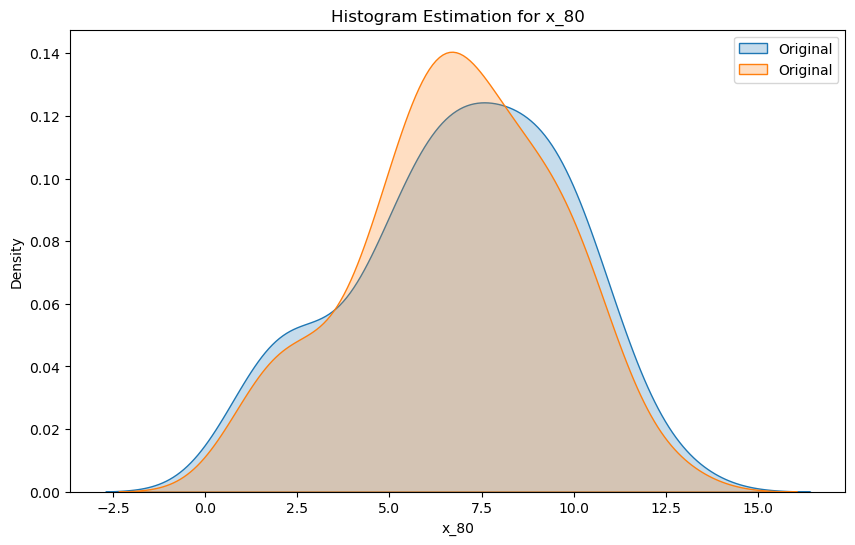

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


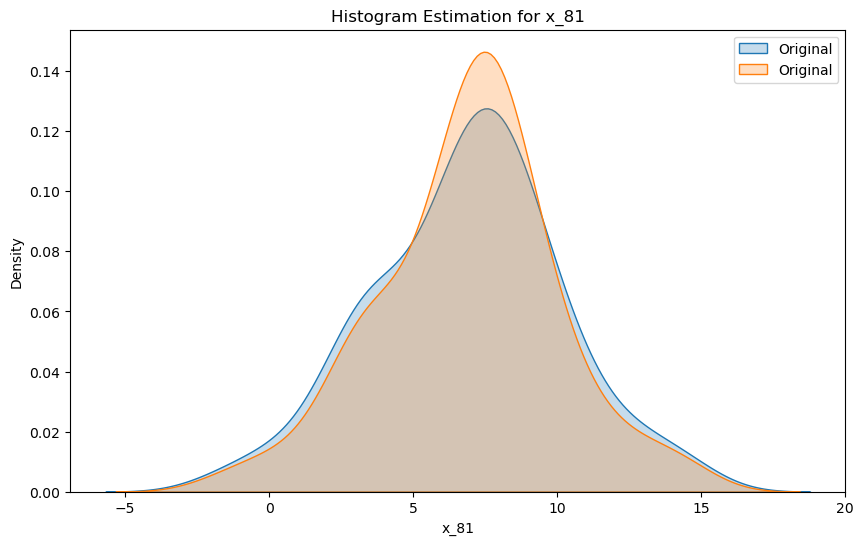

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


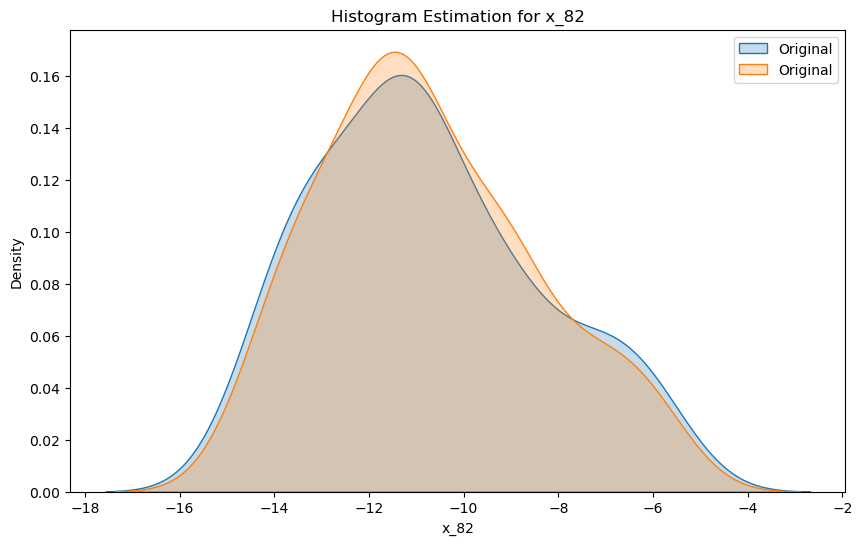

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


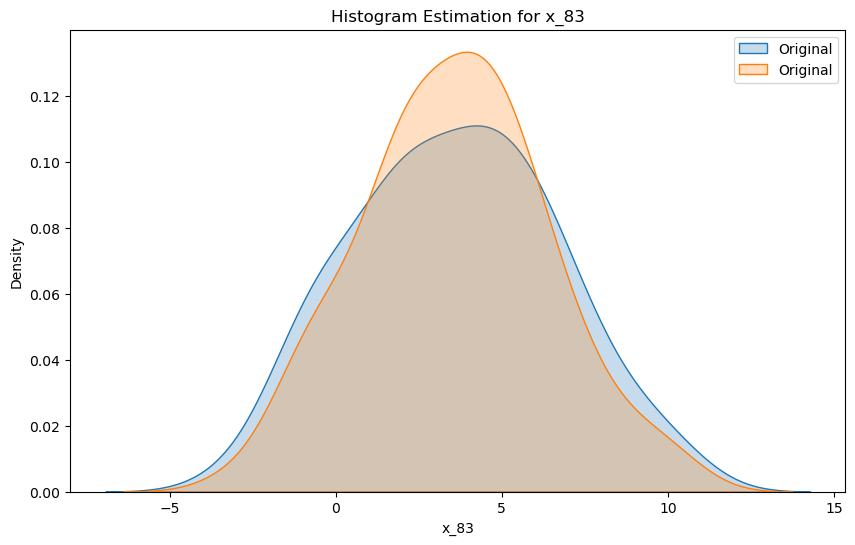

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


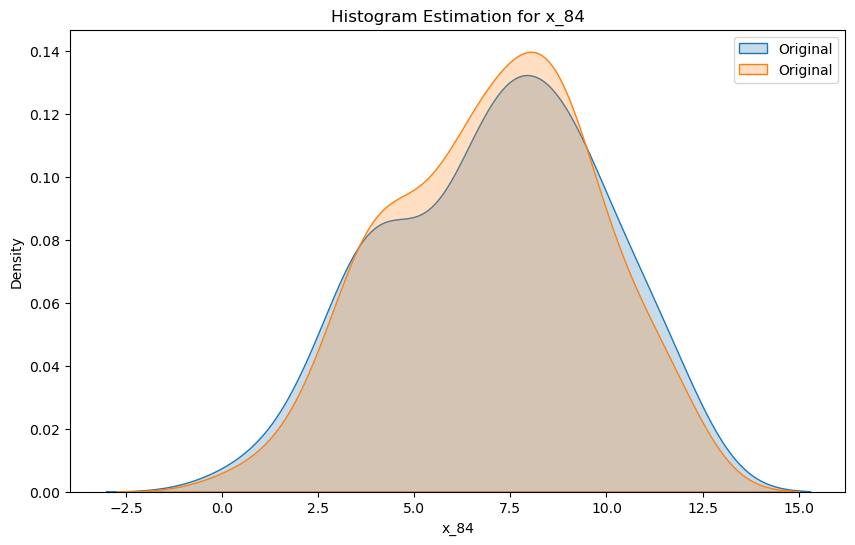

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


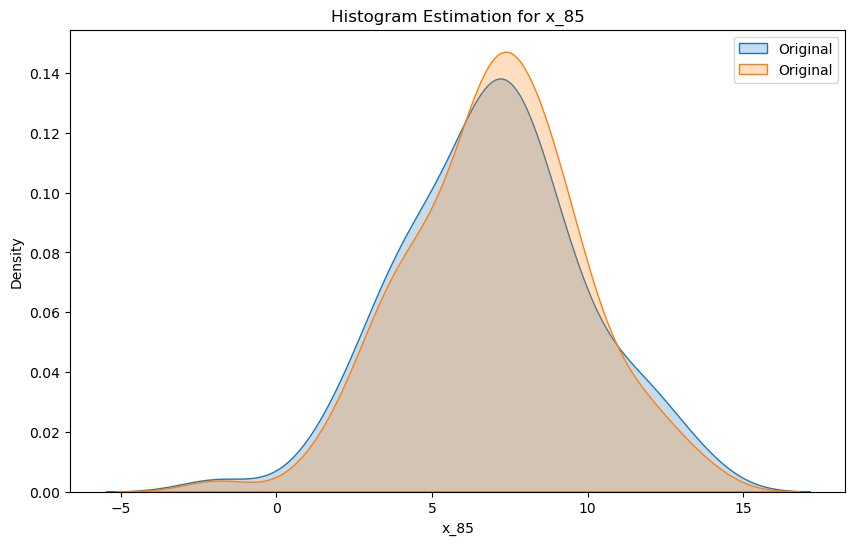

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


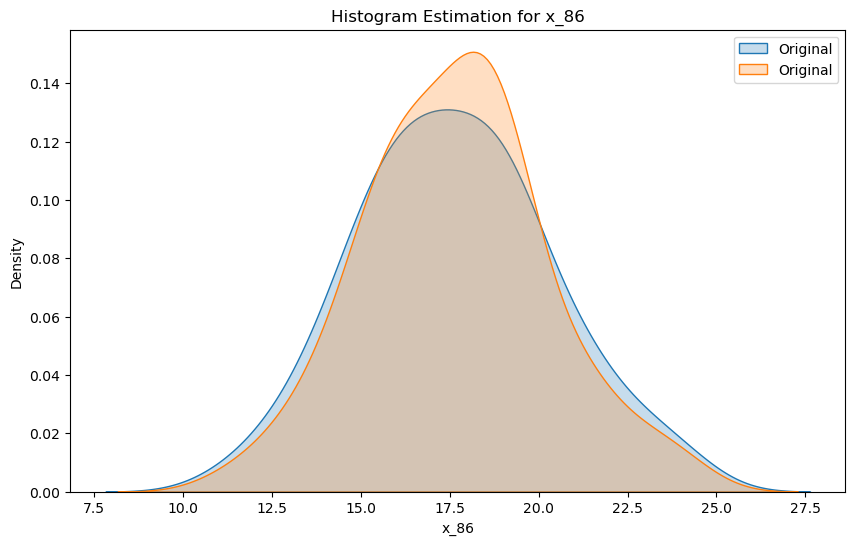

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


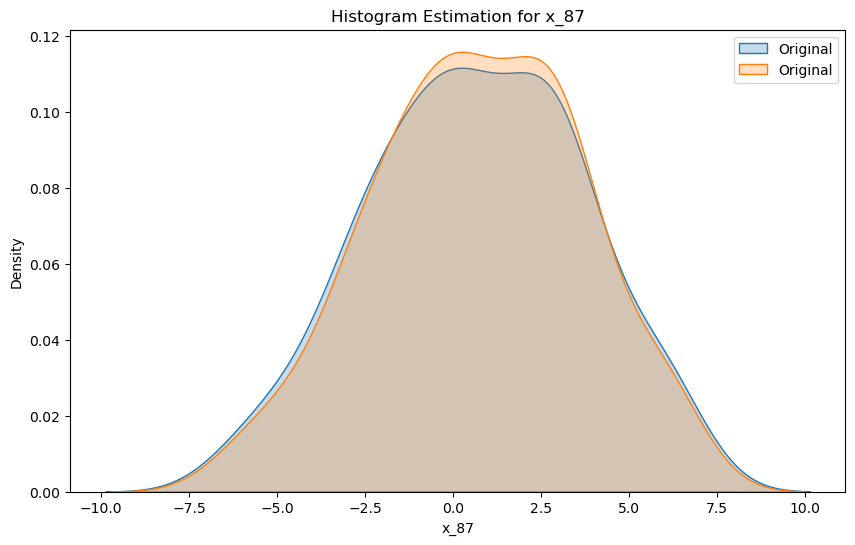

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


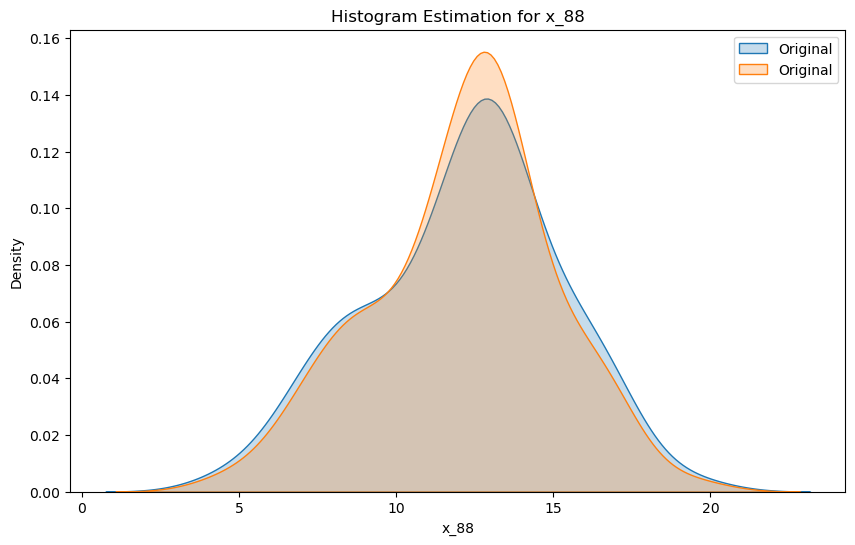

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


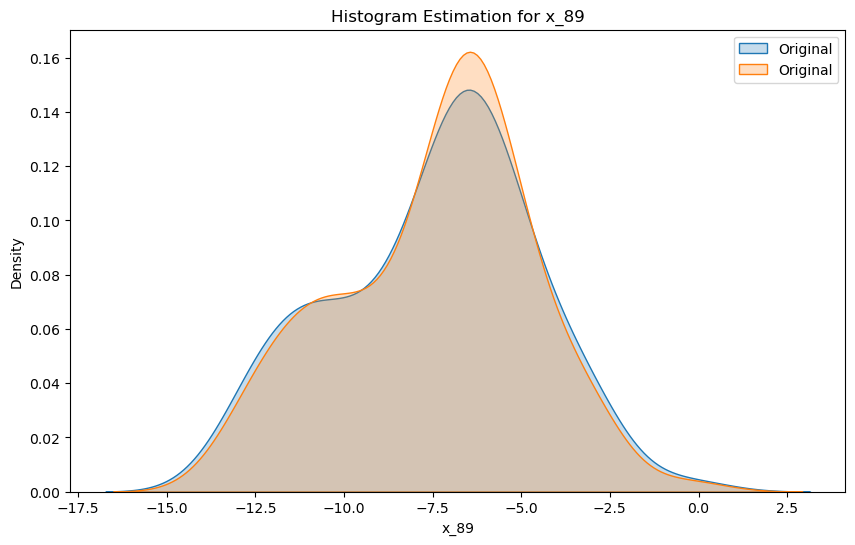

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


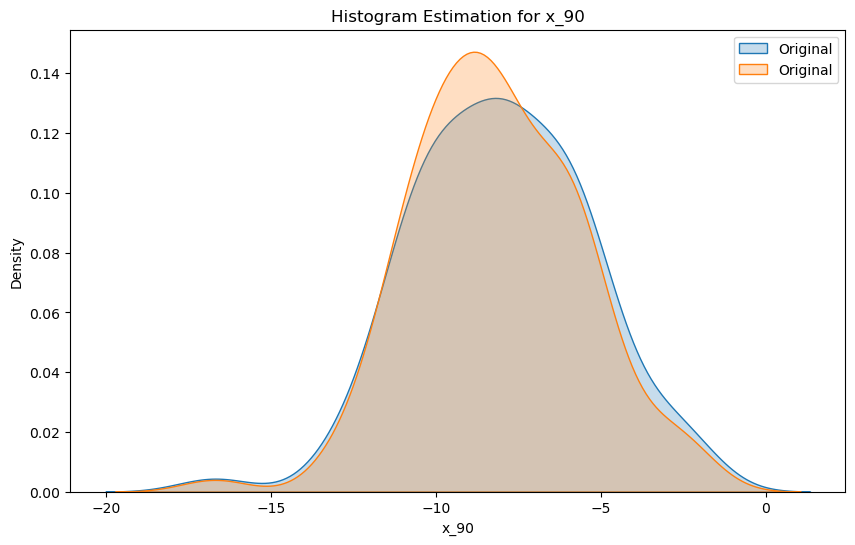

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


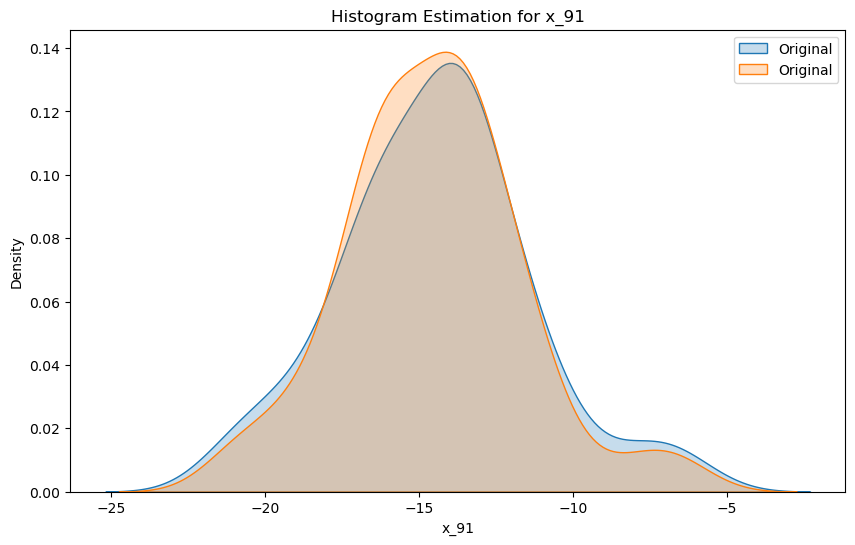

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


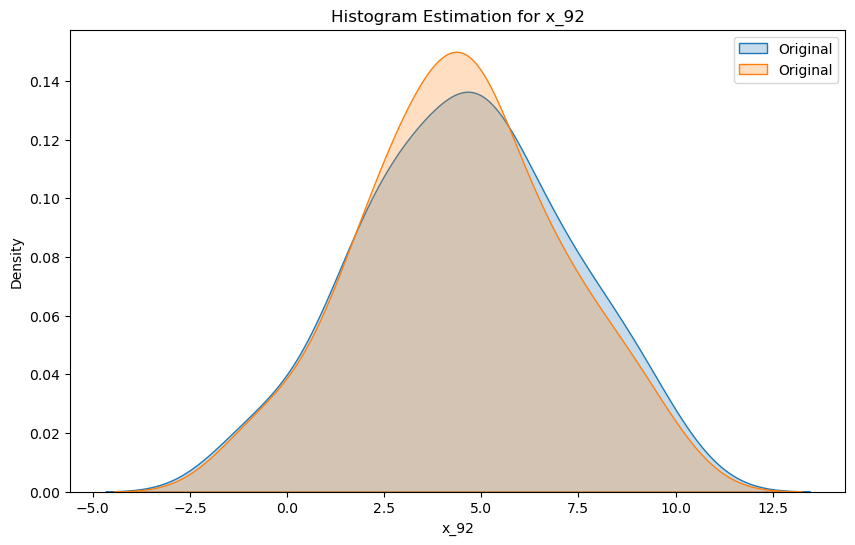

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


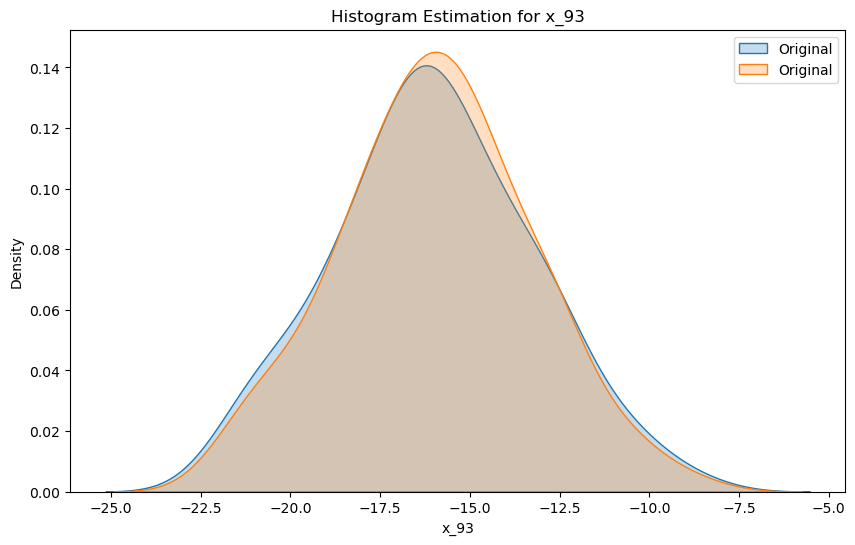

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


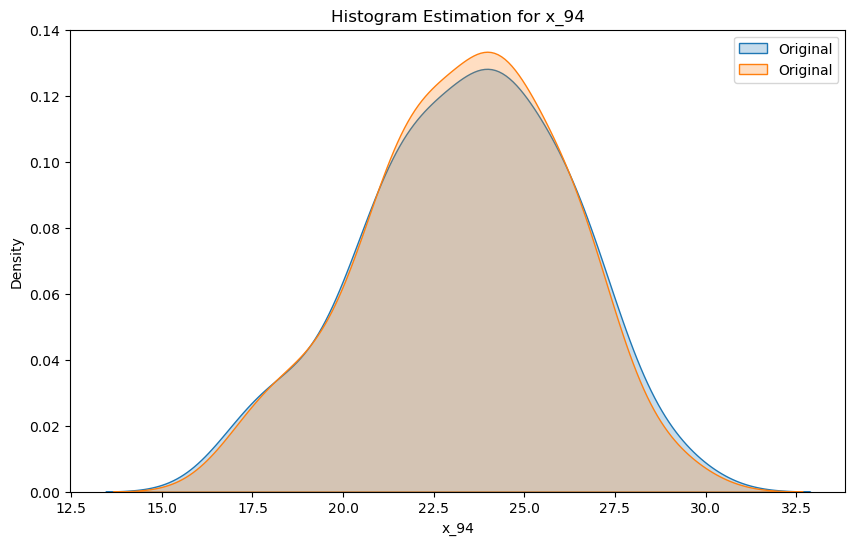

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


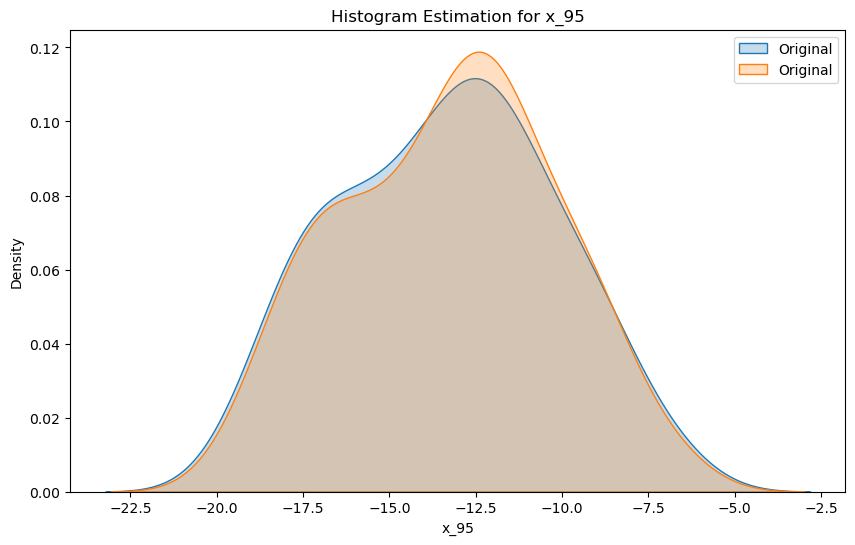

In [47]:

for col in data.columns[:96]:
    plt.figure(figsize=(10, 6))
    """     plt.hist(data[col], bins=30, density=True, alpha=0.5, color='blue',  edgecolor='black', label='Original')
    plt.hist(data_done[col], bins=30, density=True, alpha=0.5, color='orange', edgecolor='black', label='Preprossed') """
    sns.kdeplot(data[col], fill=True, label='Original')
    sns.kdeplot(data_done[col], fill=True, label='Original')
    plt.title(f'Histogram Estimation for {col}')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


## Cross validation

Nedenfor laver jeg cross validation hvor jeg ikke har normaliseret noget af mit data

Optimal alpha: 0.29758500959614526
Optimal l1-ratio: 0.5
Coefficients: [-6.41848788e-01  2.26856716e+00 -0.00000000e+00 -0.00000000e+00
  8.85032220e-01  8.71675133e-04  1.27106166e-01 -3.53206279e-01
  0.00000000e+00  5.98960740e-01 -1.39921752e-01 -0.00000000e+00
  3.16513679e-02  1.09377671e+00  2.87121067e+00 -3.01968177e+00
 -8.83045495e-01  1.24429219e+00 -3.67409568e+00 -1.02977033e+00
  8.91345595e-01  0.00000000e+00 -7.14406928e-01  1.72823640e+00
  1.23708279e+00  4.85402413e-01  2.09007478e-01 -1.23889577e-01
  3.81239707e-01  3.33648743e-01 -1.16415554e-01 -1.66393115e+00
  1.10868951e+00  4.64838745e-02 -6.77523495e-01 -5.67676187e+00
 -1.42786002e+00  2.01234995e+00  1.11694409e-01 -0.00000000e+00
  5.04455891e-01 -1.17616259e+00  4.11532183e+00  0.00000000e+00
  1.18838098e+00 -4.32761914e-01 -1.02683250e+00 -0.00000000e+00
  1.62545973e+00 -1.34152460e+00 -0.00000000e+00 -6.13419395e-01
 -5.37638484e-01  6.18165149e+00  6.78065363e-01  0.00000000e+00
  2.27493107e+00  3

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.746e+02, tolerance: 2.321e+01
  model = cd_fast.enet_coordinate_descent(


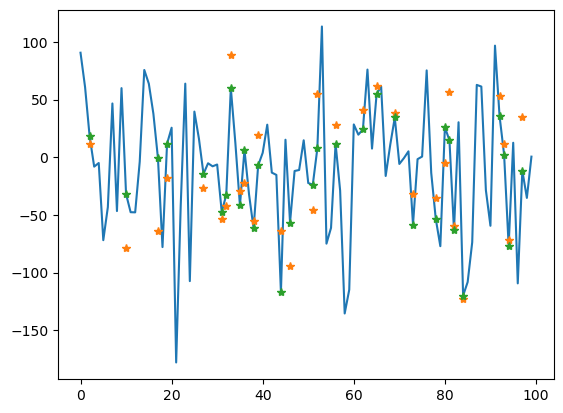

In [48]:
CV = 10

X = data_done.iloc[:, 1:]
y = data_done.iloc[:, 0]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)


elastic_net = ElasticNetCV(cv=CV)
elastic_net.fit(X_train, y_train)

# Print resultater
print("Optimal alpha:", elastic_net.alpha_)
print("Optimal l1-ratio:", elastic_net.l1_ratio_)
print("Coefficients:", elastic_net.coef_)
print("Intercept:", elastic_net.intercept_)

y_pred = elastic_net.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


plt.plot(range(data.shape[0]),data['y'])
plt.plot(y_test.index, y_pred, '*')
plt.plot(y_test.index, data['y'].iloc[y_test.index], '*')


Nedenfor laver jeg cross validation hvor jeg har normaliseret mit data

c:\Users\madsp\anaconda3\envs\DA_Env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.938e+02, tolerance: 2.321e+01
  model = cd_fast.enet_coordinate_descent(


Optimal alpha: 0.12231917016427009
Optimal l1-ratio: 0.5
Coefficients: [-1.24488396e+00  5.13902720e+00  1.78747653e+00 -1.40492551e+00
  2.80169003e+00 -0.00000000e+00  1.20810716e+00 -2.24497893e+00
 -0.00000000e+00  4.26737753e-01 -7.75682447e-02 -2.07969230e+00
  1.22930185e+00  1.51880142e+00  8.75631620e+00 -5.37847085e+00
 -1.41762476e+00  1.16272633e+00 -9.38117183e+00 -5.39843291e-01
  3.81724353e+00  9.52709645e-01 -2.75565906e+00  6.13485396e+00
  4.54262998e+00  3.38945640e+00  9.57862460e-01 -7.80042446e-01
  1.94397031e-01  3.44799696e-01 -0.00000000e+00 -4.82937861e+00
  1.35068310e+00  1.85646233e+00 -1.61948051e+00 -1.01992824e+01
 -2.37588307e+00  3.85694746e+00  2.55419279e+00 -0.00000000e+00
  2.06373319e+00 -2.86766433e-01  6.30103467e+00 -0.00000000e+00
  3.36157299e+00 -1.15451385e+00 -1.02756713e+00  2.94486980e-01
  3.62388892e+00 -1.45806389e+00  0.00000000e+00 -2.61710409e+00
 -3.46892047e-01  1.21877615e+01  2.21490635e+00  0.00000000e+00
  5.50186471e+00  6

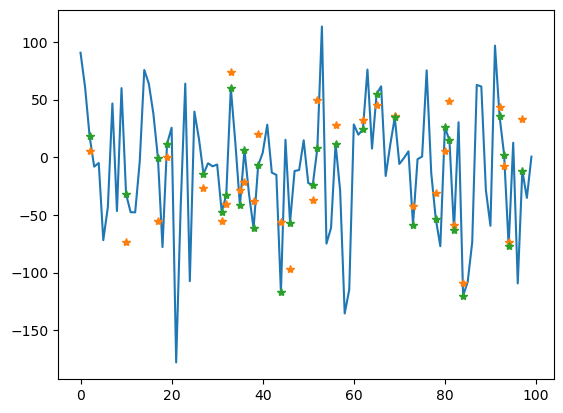

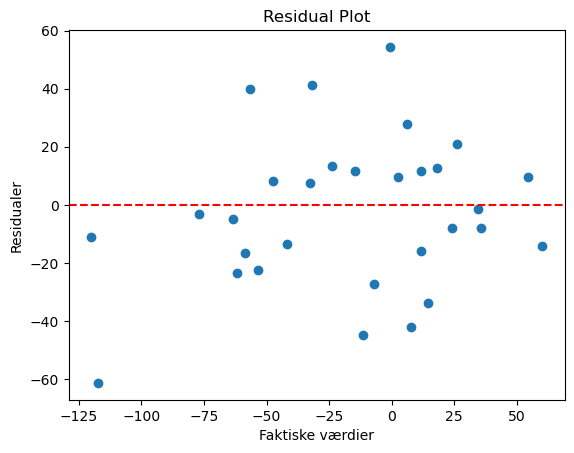

In [49]:
X_train, X_test, y_train, y_test = train_test_split(data_done.iloc[:, 1:], data_done.iloc[:, 0], test_size=0.3, random_state=1)

X_train_normalized = X_train.copy()
X_test_normalized = X_test.copy()

scaler = StandardScaler()

X_train_normalized.iloc[:, 1:96] = scaler.fit_transform(X_train.iloc[:, 1:96])
X_test_normalized.iloc[:, 1:96] = scaler.transform(X_test.iloc[:, 1:96])

# Initialisér og træn elastic net-regression
CV = 10
elastic_net = ElasticNetCV(cv=CV)
elastic_net.fit(X_train_normalized, y_train)

# Print resultater
print("Optimal alpha:", elastic_net.alpha_)
print("Optimal l1-ratio:", elastic_net.l1_ratio_)
print("Coefficients:", elastic_net.coef_)
print("Intercept:", elastic_net.intercept_)

# Forudsig med normaliseret testdata
y_pred = elastic_net.predict(X_test_normalized)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Original Scale):", mse)

plt.figure()
plt.plot(range(data.shape[0]),data['y'])
plt.plot(y_test.index, y_pred, '*')
plt.plot(y_test.index, data['y'].iloc[y_test.index], '*')

residuals = y_test - y_pred

# Plot residualerne
plt.figure()
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Tilføj en horisontal linje ved 0 for at indikere nulresidualer
plt.title('Residual Plot')
plt.xlabel('Faktiske værdier')
plt.ylabel('Residualer')
plt.show()

Nedenfor bruger jeg også GridSearchCV

In [50]:
warnings.filterwarnings("ignore")


# Split data
X_train, X_test, y_train, y_test = train_test_split(data_done.iloc[:, 1:], data_done.iloc[:, 0], test_size=0.3, random_state=1)


X_train_normalized = X_train.copy()
X_test_normalized = X_test.copy()

scaler = StandardScaler()
X_train_normalized.iloc[:, 1:96] = scaler.fit_transform(X_train.iloc[:, 1:96])
X_test_normalized.iloc[:, 1:96] = scaler.transform(X_test.iloc[:, 1:96])


param_grid = {
    'alpha': np.linspace(0, 2, 30),        # Værdier for alpha (Ridge/Lasso regularization parameter)
    'l1_ratio':np.linspace(0.1, 0.9, 30)   # Værdier for l1-ratio (andelen af L1-norm i Elastic Net)
}


elastic_net = ElasticNet()
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=CV)

grid_search.fit(X_train_normalized, y_train)

best_elastic_net = grid_search.best_estimator_

print("Optimal alpha:", grid_search.best_params_['alpha'])
print("Optimal l1-ratio:", grid_search.best_params_['l1_ratio'])
print("Coefficients:", best_elastic_net.coef_)
print("Intercept:", best_elastic_net.intercept_)


# Forudsig med normaliseret testdata
y_pred = best_elastic_net.predict(X_test_normalized)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Original Scale):", mse)

# Plot resultater
plt.plot(range(data_done.shape[0]), data_done['y'])
plt.plot(y_test.index, y_pred, '*')
plt.plot(y_test.index, data_done['y'].iloc[y_test.index], '*')
plt.show()


Optimal alpha: 0.06896551724137931
Optimal l1-ratio: 0.9
Coefficients: [ -1.32003835   7.90367706   0.          -0.          -0.05141405
   0.           0.           0.           0.           2.80504308
   0.56148564  -0.           2.74572812   2.43801852   8.60191121
  -7.29928107  -0.70553324   0.         -13.03246569  -1.48240451
   4.82704521   0.68013262  -1.09314482   7.47494404   5.79580612
   2.34096909  -0.          -0.54725252  -0.11917476  -0.
  -0.          -2.12799331   0.           3.32974096  -2.54627325
 -12.05814436  -4.57368533   2.69767218   0.71662912   1.96688076
   0.94935013  -4.01368393  10.67797393   0.           0.
  -3.07827934  -1.33547392   0.           6.08175438  -2.91588784
  -0.          -2.59588483  -0.          10.5526004    2.5535258
   0.           4.1194734   10.14660607  -0.           7.67662322
  -0.          18.01051036  -9.24624887  -3.24363987  -1.47916624
  -0.          -0.           3.81551121  -6.73286716   0.17042972
   0.38422984  -2.4323

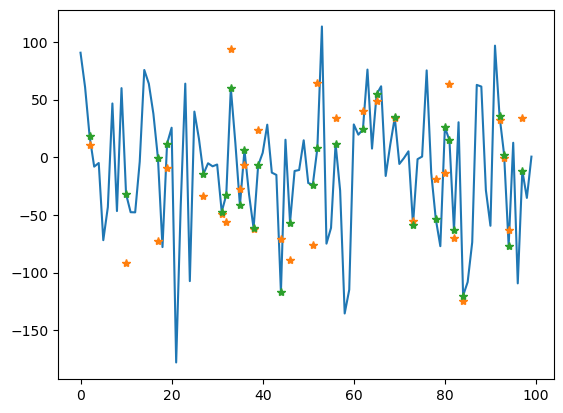

In [ ]:
warnings.filterwarnings("ignore")

X_train, X_test, y_train, y_test = train_test_split(data_done.iloc[:, 1:], data_done.iloc[:, 0], test_size=0.3, random_state=1)


X_train_normalized = X_train.copy()
X_test_normalized = X_test.copy()


scaler = StandardScaler()
X_train_normalized.iloc[:, 1:96] = scaler.fit_transform(X_train.iloc[:, 1:96])
X_test_normalized.iloc[:, 1:96] = scaler.transform(X_test.iloc[:, 1:96])

param_grid = {
    'alpha': np.linspace(0, 2, 30),        # Værdier for alpha (Ridge/Lasso regularization parameter)
    'l1_ratio': np.linspace(0.1, 0.9, 30)   # Værdier for l1-ratio (andelen af L1-norm i Elastic Net)
}


elastic_net = ElasticNet()
CV = 10
grid_search = GridSearchCV(estimator=elastic_net, param_grid=param_grid, cv=CV, scoring='neg_mean_squared_error')


grid_search.fit(X_train_normalized, y_train)

best_elastic_net = grid_search.best_estimator_

# Print resultater
print("Optimal alpha:", grid_search.best_params_['alpha'])
print("Optimal l1-ratio:", grid_search.best_params_['l1_ratio'])
print("Coefficients:", best_elastic_net.coef_)
print("Intercept:", best_elastic_net.intercept_)
print("Mindste Mean Squared Error:", -grid_search.best_score_)

# Forudsig med normaliseret testdata
y_pred = best_elastic_net.predict(X_test_normalized)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (Original Scale):", mse)

# Plot resultater
plt.plot(range(data_done.shape[0]), data_done['y'])
plt.plot(y_test.index, y_pred, '*')
plt.plot(y_test.index, data_done['y'].iloc[y_test.index], '*')
plt.show()
